# Propaganda Detection Model
### Advanced Natural Language Processing 968G5

Felipe Martín CandNo: 260774

# Contents:

* [Imports all requirements](#first-bullet)
* [Data Analyisis](#second-bullet)
* [Propaganda/non-propaganda classification model](#3-bullet)
** [Word2Vec and Logistic Regression](#3.1-bullet)
** [BERT with Adamw Optimiser](#3.2-bullet)
* [Propaganda Methods Classification](#4-bullet)
** [Word2Vec and Decision Trees](#4.1-bullet)
** [BERT with Adamw Optimiser](#4.2-bullet)
* [References](#5-bullet)


# Imports all requirements <a class="anchor" id="first-bullet"></a>

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import os    
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import string
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from transformers import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd 
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [24]:
#Install the transformers and torch libraries. 
#These libraries are required to use the BERT implementation and tensor manipulation in PyTorch.
!pip install transformers
!pip install torch

In [5]:
#is used in preprocessing to remove stop words.
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FelipeMartin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FelipeMartin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
!pip install --upgrade gensim

  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\FelipeMartin\\anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [7]:
!pip install --upgrade numpy

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
tensorflow-intel 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.3 which is incompatible.
tensorboard 2.11.2 requires protobuf<4,>=3.9.2, but you have protobuf 4.22.3 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [45]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [46]:
conda install --yes freetype=2.10.4

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [47]:
   os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Data Analysis <a class="anchor" id="second-bullet"></a>

## Training dataset

In [54]:
# Training are loaded into a DataFrame pandas objects. 
train_data = pd.read_csv('propaganda_train.tsv', sep='\t')

# display the first 5 records of the DataFrame
train_data

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [55]:
# Count the number of unique values in the column 'label'.
count_values = train_data['label'].value_counts()
print(count_values)

not_propaganda               1191
exaggeration,minimisation     164
causal_oversimplification     158
name_calling,labeling         157
loaded_language               154
appeal_to_fear_prejudice      151
flag_waving                   148
repetition                    147
doubt                         144
Name: label, dtype: int64


In [56]:
# Create a new column indicating whether it is propaganda or not.
train_data['is_propaganda'] = train_data['label'].apply(lambda x: 'No Propaganda' if x == 'not_propaganda' else 'Propaganda')

In [57]:
# Count the number of unique values in the column 'is_propaganda'.
count_values = train_data['is_propaganda'].value_counts()
print(count_values)

Propaganda       1223
No Propaganda    1191
Name: is_propaganda, dtype: int64


In [58]:
train_data

,label,tagged_in_context,is_propaganda
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",No Propaganda
1,not_propaganda,This declassification effort <BOS> won’t make ...,No Propaganda
2,flag_waving,The Obama administration misled the <BOS> Amer...,Propaganda
3,not_propaganda,“It looks like we’re capturing the demise of t...,No Propaganda
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",No Propaganda
...,...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,No Propaganda
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,No Propaganda
2411,not_propaganda,What has been done: there has been work on for...,No Propaganda
2412,not_propaganda,This is <BOS> the law of gradualness not the g...,No Propaganda


In [59]:
sns.set_theme(style="whitegrid")

In [60]:
#Grouping data for graphing
grouped_df_general = train_data.groupby(['is_propaganda']).size().reset_index(name='count')
grouped_df_specific = train_data.groupby(['label']).size().reset_index(name='count')


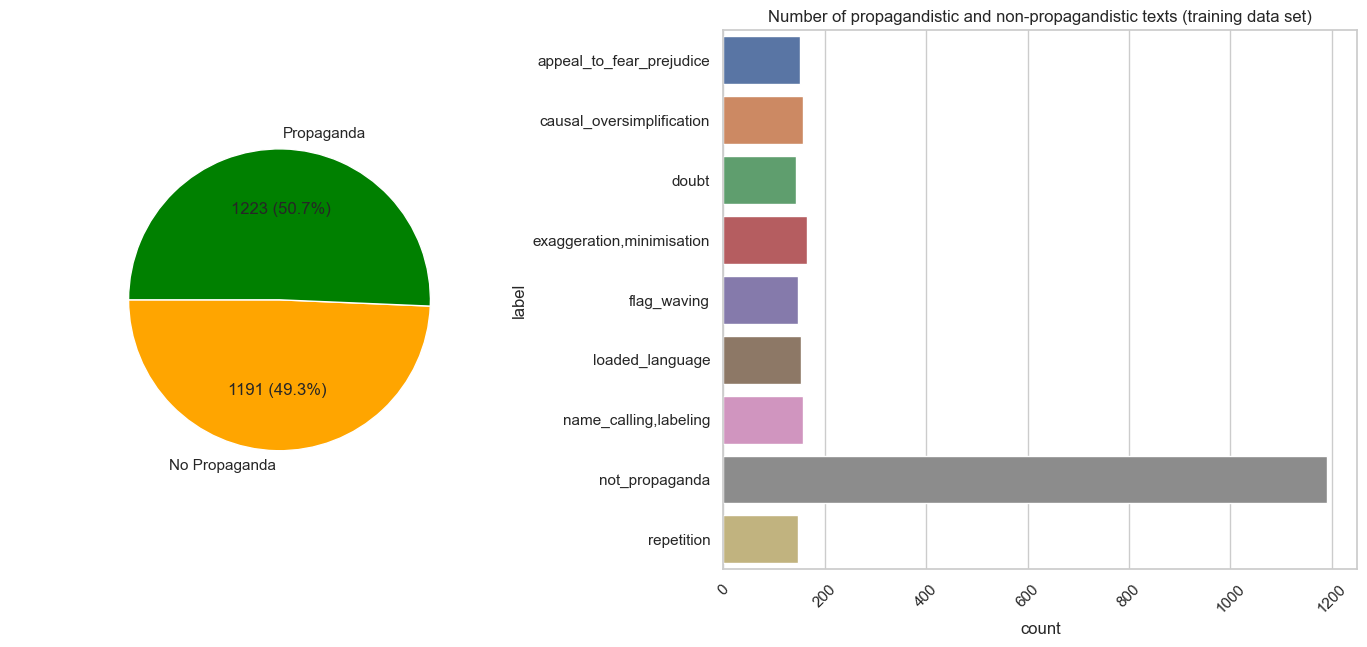

In [61]:
fig,axs = plt.subplots(ncols=2, figsize=(18,7))

# Creating a histogram
axs[0].pie(grouped_df_general['count'], labels=grouped_df_general['is_propaganda'], autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(grouped_df_general['count']) / 100, p), startangle=180, colors=['orange', 'green'], radius=0.7)
sns.barplot(y='label', x='count', data=grouped_df_specific,ax=axs[1])
plt.xticks(rotation=45)

# Adding labels to the chart
plt.title('Number of propagandistic and non-propagandistic texts (training data set)')

# Show the graph
plt.show()

## Testing dataset

In [38]:
# Training are loaded into a DataFrame pandas objects. 
test_data = pd.read_csv('propaganda_val.tsv', sep='\t')

# display the first 5 records of the DataFrame
test_data

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


In [39]:
# Count the number of unique values in the column 'label'.
count_values = test_data['label'].value_counts()
print(count_values)

not_propaganda               301
appeal_to_fear_prejudice      43
flag_waving                   39
doubt                         38
loaded_language               37
repetition                    32
causal_oversimplification     31
name_calling,labeling         31
exaggeration,minimisation     28
Name: label, dtype: int64


In [40]:
# Create a new column indicating whether it is propaganda or not.
test_data['is_propaganda'] = test_data['label'].apply(lambda x: 'No Propaganda' if x == 'not_propaganda' else 'Propaganda')

In [41]:
# Count the number of unique values in the column 'is_propaganda'.
count_values = test_data['is_propaganda'].value_counts()
print(count_values)

No Propaganda    301
Propaganda       279
Name: is_propaganda, dtype: int64


In [42]:
#Grouping data for graphing
grouped_df_general = test_data.groupby(['is_propaganda']).size().reset_index(name='count')
grouped_df_specific = test_data.groupby(['label']).size().reset_index(name='count')

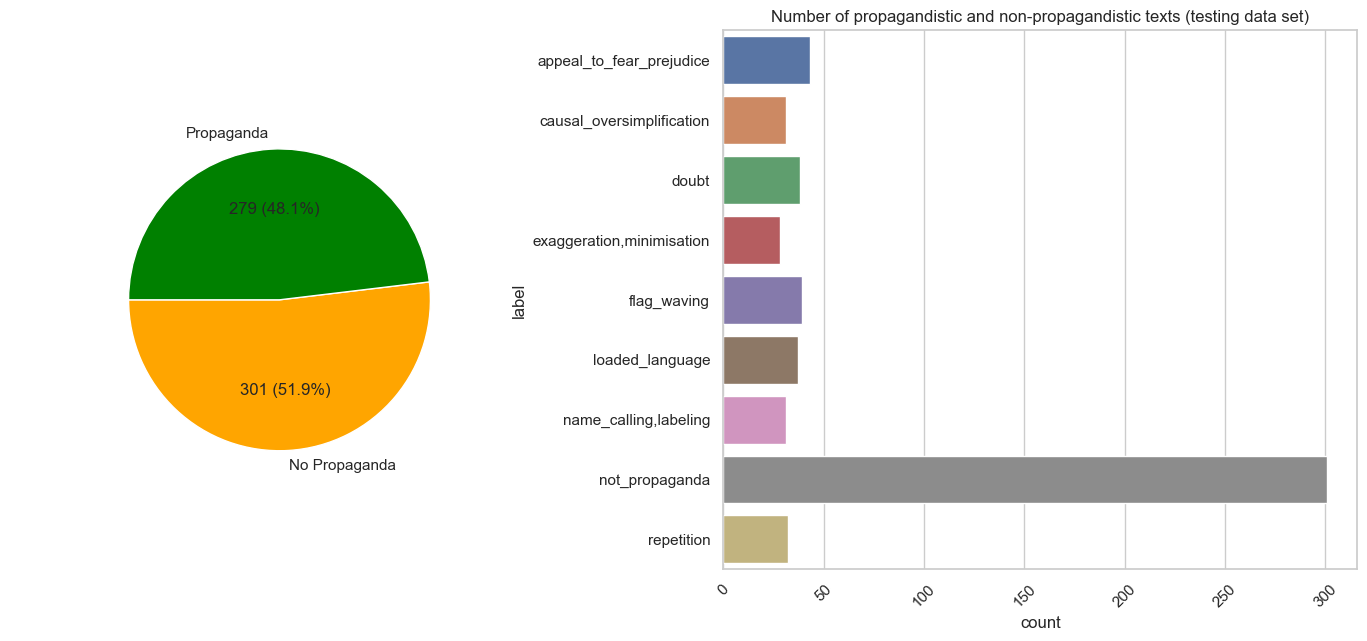

In [43]:
fig,axs = plt.subplots(ncols=2, figsize=(18,7))

# Creating a histogram
axs[0].pie(grouped_df_general['count'], labels=grouped_df_general['is_propaganda'], autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(grouped_df_general['count']) / 100, p), startangle=180, colors=['orange', 'green'], radius=0.7)
sns.barplot(y='label', x='count', data=grouped_df_specific,ax=axs[1])
plt.xticks(rotation=45)

# Adding labels to the chart
plt.title('Number of propagandistic and non-propagandistic texts (testing data set)')

# Show the graph
plt.show()

# Propaganda/non-propaganda classification model <a class="anchor" id="3-bullet"></a>

## Word2Vec and Logistic Regression <a class="anchor" id="3.1-bullet"></a>

### Evaluating  PreProcess

In [64]:
# A text pre-processing function is defined to remove empty 
#words and text punctuations from each record in the dataset. 
#All letters are also converted to lower case.
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords and token.isalnum()]
    return ' '.join(tokens)

# The preprocessing function is applied to the texts of each record in the training and test set, 
# and the results are stored in two new columns in the DataFrames. 
#This pre-processing step is important to reduce noise in the text data and make it more suitable for modelling.
train_data['tokens'] = train_data['tagged_in_context'].apply(preprocess)
test_data['tokens'] = test_data['tagged_in_context'].apply(preprocess)

# A Word2Vec word embedding model is trained on the pre-processed texts of the training set. 
#The Word2Vec model converts each word into a fixed-length numeric vector representing 
#its meaning in the context of the surrounding words. 
#The model is useful for capturing the semantics of words and the relationships between them.
model = Word2Vec(train_data['tokens'], vector_size= 200, window=10, min_count=10)

# Convert the preprocessed text data into numerical vectors using word2vec
#A function is defined to convert pre-processed texts into numeric vectors using the trained Word2Vec model. 
#The function takes a list of words and returns a numeric vector representing the text as a whole. The function averages 
#the word vectors of each word in the text and returns the average vector as a numerical representation of the text.
def vectorize(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv.key_to_index:
            vectors.append(model.wv[token])
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(vectors, axis=0)

# Create two datasets, one with preprocessed data and another without
#The vectorisation function is applied to the pre-processed texts of each record in the training and test set, 
#and the resulting numeric vectors are stored in two new columns in the DataFrames. 
#The numeric vectors will be used as input features to train the logistic regression model.
X_train_pre = np.stack(train_data['tokens'].apply(lambda x: vectorize(x, model)))
X_train_no_pre = np.stack(train_data['tagged_in_context'].apply(lambda x: vectorize(x, model)))
y_train = train_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})

X_test_pre = np.stack(test_data['tokens'].apply(lambda x: vectorize(x, model)))
X_test_no_pre = np.stack(test_data['tagged_in_context'].apply(lambda x: vectorize(x, model)))
y_test = test_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})


#A logistic regression model is trained using the prepared training data. 
#The logistic regression model is fitted to the numerical input vectors and the corresponding class 
#labels, allowing it to learn a classification function that maps the input vectors to the class labels.

# Train a logistic regression model on the preprocessed data and evaluate using cross-validation
clf_pre = LogisticRegression(C=100)
scores_pre = cross_val_score(clf_pre, X_train_pre, y_train, cv=5)

# Train a logistic regression model on the non-preprocessed data and evaluate using cross-validation
clf_no_pre = LogisticRegression(C=100)
scores_no_pre = cross_val_score(clf_no_pre, X_train_no_pre, y_train, cv=5)

# Print the average accuracy scores for both models
print('Accuracy with preprocessing:', np.mean(scores_pre))
print('Accuracy without preprocessing:', np.mean(scores_no_pre))

Accuracy with preprocessing: 0.596095461457179
Accuracy without preprocessing: 0.5608901832427


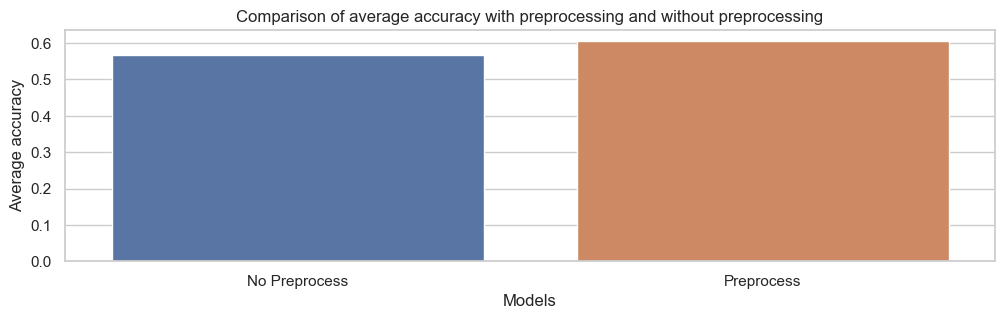

In [371]:
models = ['Con preprocesamiento', 'Sin preprocesamiento']

# Create a dictionary with the model names and their average accuracy scores
model_scores = {'Preprocess': np.mean(scores_pre), 'No Preprocess': np.mean(scores_no_pre)}

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Average Accuracy'])
df_sorted = df.sort_values(by='Average Accuracy', ascending=True)
# Create a figure and an axis
fig = plt.subplots(figsize=(12, 3))

# Creating a bar chart
sns.barplot(x=df_sorted.index, y='Average Accuracy', data=df_sorted)

# add labels
plt.title('Comparison of average accuracy with preprocessing and without preprocessing')
plt.xlabel('Models')
plt.ylabel('Average accuracy')

# show the graph
plt.show()

### Word2Vec Hyperparameter Tuning

In [317]:
# Load the training and testing data
train_data = pd.read_csv('propaganda_train.tsv', sep='\t')
test_data = pd.read_csv('propaganda_val.tsv', sep='\t')

# Preprocess the text data
stopwords = nltk.corpus.stopwords.words('english')
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords and token.isalnum()]
    return ' '.join(tokens)

train_data['tokens'] = train_data['tagged_in_context'].apply(preprocess)
test_data['tokens'] = test_data['tagged_in_context'].apply(preprocess)

# Define a function to train a Word2Vec model and return its accuracy
def train_w2v_and_evaluate(size, window, min_count):
    # Train a word embedding model
    model = Word2Vec(train_data['tokens'], vector_size=size, window=window, min_count=min_count)

    # Convert the preprocessed text data into numerical vectors using word2vec
    def vectorize(tokens, model):
        vectors = []
        for token in tokens:
            if token in model.wv.key_to_index:
                vectors.append(model.wv[token])
        if len(vectors) == 0:
            return np.zeros(model.vector_size)
        else:
            return np.mean(vectors, axis=0)

    train_data['vectors'] = train_data['tokens'].apply(lambda x: vectorize(x, model))
    test_data['vectors'] = test_data['tokens'].apply(lambda x: vectorize(x, model))

    # Train a logistic regression model on the numerical vectors and the corresponding labels
    Xtrain = np.stack(train_data['vectors'])
    ytrain = train_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})
    Xtest = np.stack(test_data['vectors'])
    ytest = test_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})

    clf = LogisticRegression()
    clf.fit(Xtrain, ytrain)

    # Evaluate the trained model on the testing data
    ypred = clf.predict(Xtest)
    accuracy = accuracy_score(ytest, ypred)

    return accuracy

# Define the hyperparameters to evaluate

params_w2v = {
    'vector_size': [50, 100, 200],
    'window': [2, 5, 10],
    'min_count': [1, 5, 10] }


# Use itertools to generate all possible combinations of the hyperparameters
combinations = list(itertools.product(*params_w2v.values()))

# Evaluate the accuracy for each combination of hyperparameters
results = []
i=0
for combination in combinations:
    #print(combination[0],combination[1],combination[2])
    accuracy = train_w2v_and_evaluate(combination[0],combination[1],combination[2])
    results.append((combination, accuracy))
    
# Sort the results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Print the results and select the hyperparameters with the highest accuracy
for result in results:
    print('Hyperparameters:', result[0])
    print('Accuracy:', result[1])
    print()
    if result[1] == results[0][1]:
        best_params_w2v = {'vector_size': result[0][0], 'window': result[0][1], 'min_count': result[0][2]}

# Train a Word2Vec model with the best hyperparameters and evaluate its accuracy
model = Word2Vec(train_data['tokens'], vector_size=best_params_w2v['vector_size'], window=best_params_w2v['window'], min_count=best_params_w2v['min_count'])
accuracy = train_w2v_and_evaluate(best_params_w2v['vector_size'], best_params_w2v['window'], best_params_w2v['min_count'])

# Print the BEST HYPERPARAMETERS
print('Best hyperparameters:', best_params_w2v)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FelipeMartin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FelipeMartin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Hyperparameters: (200, 10, 10)
Accuracy: 0.6206896551724138

Hyperparameters: (200, 2, 1)
Accuracy: 0.6137931034482759

Hyperparameters: (200, 5, 5)
Accuracy: 0.6137931034482759

Hyperparameters: (50, 2, 1)
Accuracy: 0.6103448275862069

Hyperparameters: (50, 5, 10)
Accuracy: 0.6103448275862069

Hyperparameters: (100, 5, 10)
Accuracy: 0.6086206896551725

Hyperparameters: (200, 5, 1)
Accuracy: 0.6086206896551725

Hyperparameters: (100, 2, 1)
Accuracy: 0.6068965517241379

Hyperparameters: (50, 10, 1)
Accuracy: 0.603448275862069

Hyperparameters: (50, 2, 10)
Accuracy: 0.6017241379310345

Hyperparameters: (100, 2, 10)
Accuracy: 0.6017241379310345

Hyperparameters: (200, 2, 5)
Accuracy: 0.6017241379310345

Hyperparameters: (50, 5, 5)
Accuracy: 0.6

Hyperparameters: (100, 2, 5)
Accuracy: 0.5982758620689655

Hyperparameters: (50, 5, 1)
Accuracy: 0.596551724137931

Hyperparameters: (100, 5, 5)
Accuracy: 0.596551724137931

Hyperparameters: (200, 5, 10)
Accuracy: 0.596551724137931

Hyperparameter

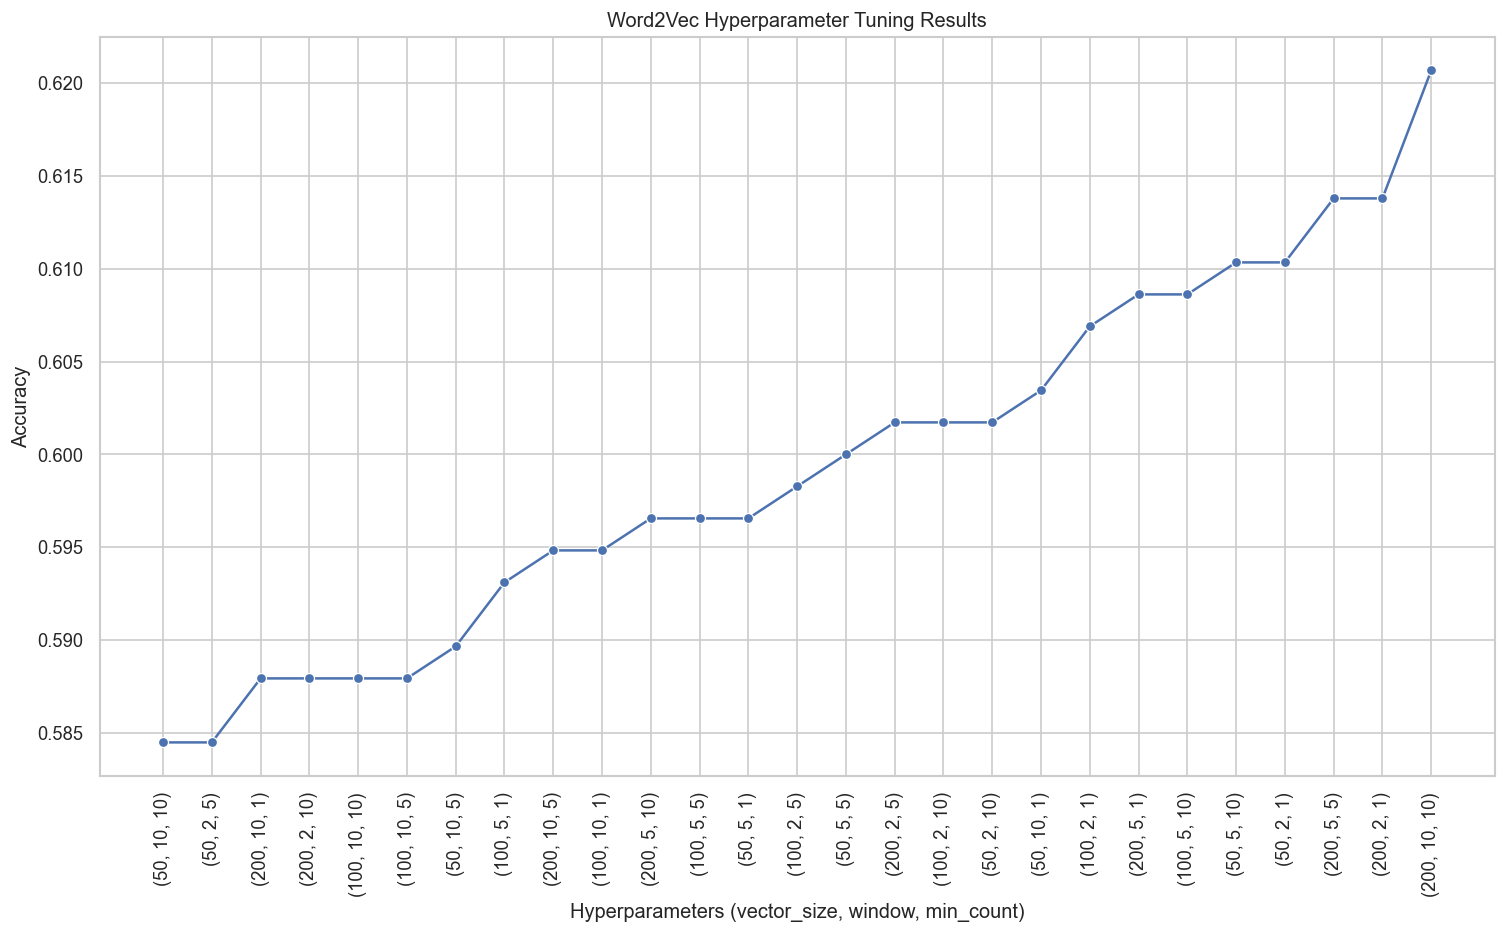

In [347]:
#All combinations of hyperparameters are plotted.
plt.figure(figsize=(15,8),dpi=120)
# Extract the accuracy values and hyperparameters from the results
accuracies = [result[1] for result in results]
hyperparams = [str(result[0]) for result in results]

df = pd.DataFrame({'hyperparams': hyperparams, 'accuracies': accuracies})
df_sorted = df.sort_values(by='accuracies', ascending=True)

# Plot the accuracies for each hyperparameter combination
sns.lineplot(x='hyperparams', y='accuracies', data=df_sorted,marker='o')
plt.xticks(rotation=90)
plt.xlabel('Hyperparameters (vector_size, window, min_count)')
plt.ylabel('Accuracy')
plt.title('Word2Vec Hyperparameter Tuning Results')
plt.show()

### Logistic Regression Hyperparameter Tuning


In [380]:
# Preprocess the text data
stopwords = nltk.corpus.stopwords.words('english')
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords and token.isalnum()]
    return ' '.join(tokens)

train_data['tokens'] = train_data['tagged_in_context'].apply(preprocess)
test_data['tokens'] = test_data['tagged_in_context'].apply(preprocess)

# Train a word embedding model
model = Word2Vec(train_data['tokens'], min_count=1)

# Convert the preprocessed text data into numerical vectors using word2vec
def vectorize(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv.key_to_index:
            vectors.append(model.wv[token])
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(vectors, axis=0)

train_data['vectors'] = train_data['tokens'].apply(lambda x: vectorize(x, model))
test_data['vectors'] = test_data['tokens'].apply(lambda x: vectorize(x, model))

# Train a logistic regression model on the numerical vectors and the corresponding labels
X_train = np.stack(train_data['vectors'])
y_train = train_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})
X_test = np.stack(test_data['vectors'])
y_test = test_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})

# Define the hyperparameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search to find the best hyperparameters
clf = LogisticRegression()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Evaluate the trained model on the testing data
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Best hyperparameters:', grid_search.best_params_)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print(classification_report(y_test, y_pred))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FelipeMartin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FelipeMartin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Best hyperparameters: {'C': 100}
Accuracy: 0.6103448275862069
Precision: 0.6202605559225806
Recall: 0.6103448275862069
F1-score: 0.6066987021978835
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       279
           1       0.66      0.51      0.58       301

    accuracy                           0.61       580
   macro avg       0.62      0.61      0.61       580
weighted avg       0.62      0.61      0.61       580



In [381]:
grid_search.cv_results_['mean_test_score']

array([0.50662784, 0.51863955, 0.57166224, 0.57828235, 0.58532168,
       0.60438133])

In [382]:
#for params, mean_accuracy, std_accuracy in grid.cv_results_:
#    accuracy_values.append(mean_accuracy)
    
accuracy_values = []
for i in grid_search.cv_results_['mean_test_score']:
    accuracy_values.append(i)
    #print(mean_accuracy.value)
    #accuracy_values.append(mean_accuracy)

In [383]:
print(accuracy_values)

[0.5066278360523354, 0.5186395539633858, 0.5716622423820692, 0.578282346674914, 0.5853216841490341, 0.6043813303780831]


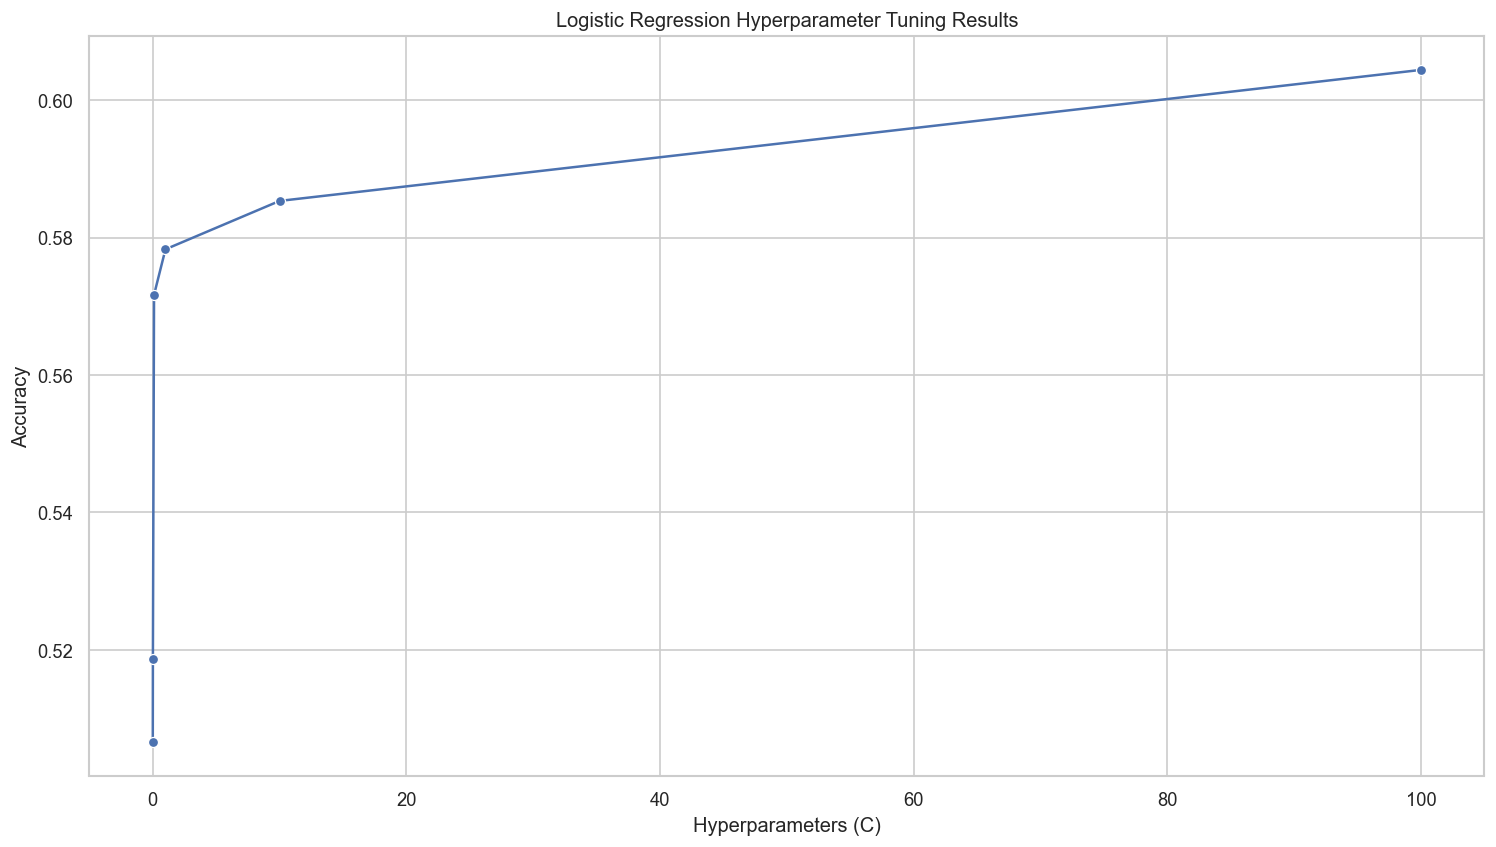

In [384]:
df = pd.DataFrame({'C': param_grid['C'], 'Accuracy': accuracy_values})

plt.figure(figsize=(15,8),dpi=120)

sns.lineplot(data=df, y='Accuracy', x='C',marker='o')
plt.xlabel('Hyperparameters (C)')
plt.title('Logistic Regression Hyperparameter Tuning Results')
plt.show()

### Word2Vec and Logistic Regression Final model

In [9]:
# Preprocess the text data
stopwords = nltk.corpus.stopwords.words('english')
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords and token.isalnum()]
    return ' '.join(tokens)

train_data['tokens'] = train_data['tagged_in_context'].apply(preprocess)
test_data['tokens'] = test_data['tagged_in_context'].apply(preprocess)

# Train a word embedding model
model = Word2Vec(train_data['tokens'], vector_size= 200, window=10, min_count=10)

# Convert the preprocessed text data into numerical vectors using word2vec
def vectorize(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv.key_to_index:
            vectors.append(model.wv[token])
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(vectors, axis=0)

train_data['vectors'] = train_data['tokens'].apply(lambda x: vectorize(x, model))
test_data['vectors'] = test_data['tokens'].apply(lambda x: vectorize(x, model))

# Train a logistic regression model on the numerical vectors and the corresponding labels
X_train = np.stack(train_data['vectors'])
y_train = train_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})
X_test = np.stack(test_data['vectors'])
y_test = test_data['label'].map({'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1, 'causal_oversimplification': 0})

clf = LogisticRegression(C=100)
clf.fit(X_train, y_train)

# Evaluate the trained model on the testing data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print(classification_report(y_test, y_pred))

Accuracy: 0.6103448275862069
Precision: 0.6202605559225806
Recall: 0.6103448275862069
F1-score: 0.6066987021978835
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       279
           1       0.66      0.51      0.58       301

    accuracy                           0.61       580
   macro avg       0.62      0.61      0.61       580
weighted avg       0.62      0.61      0.61       580



C:\Users\FelipeMartin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model accuracy on test set is: 62.59%


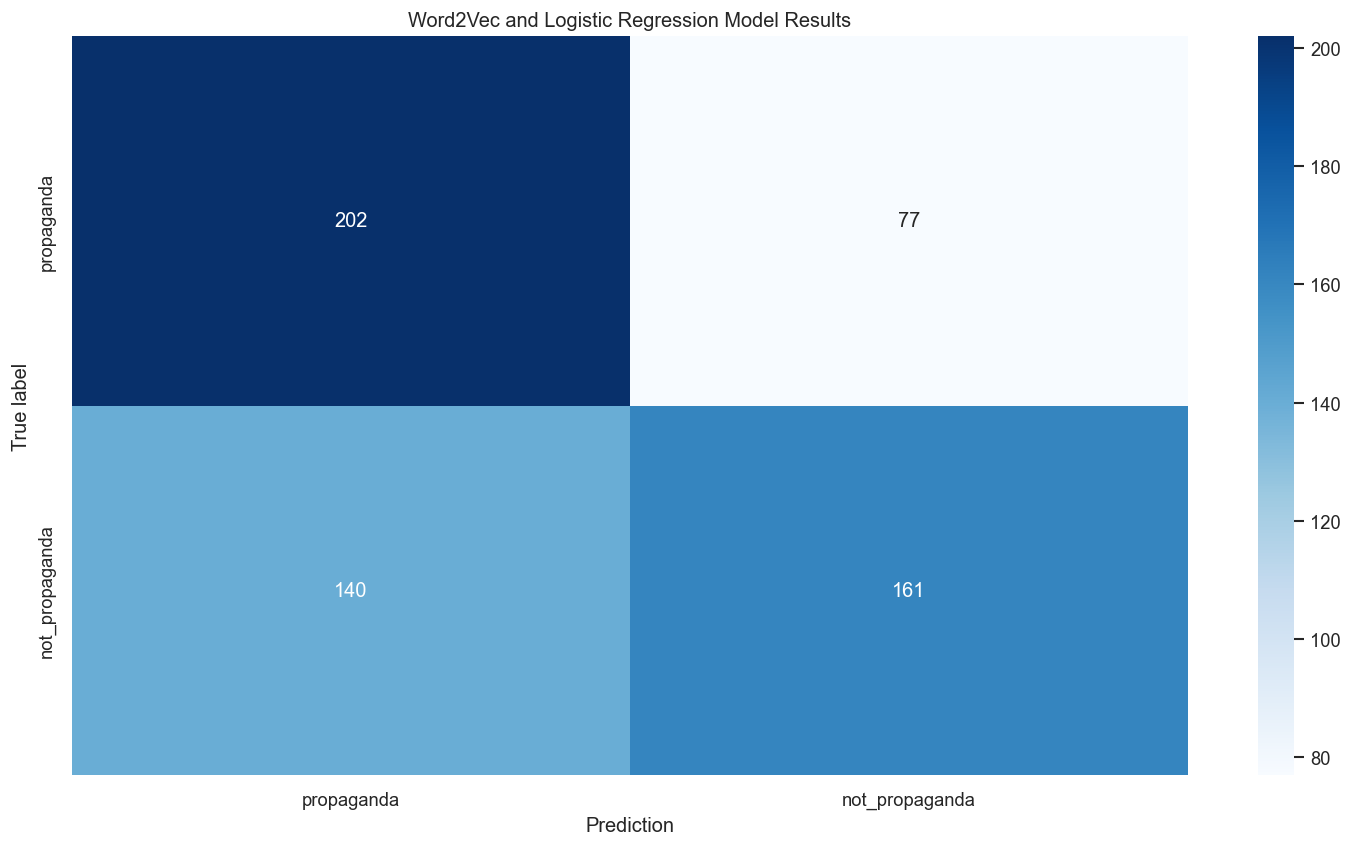

In [349]:
plot_confusion_matrix(clf,X_test,y_test,"Word2Vec and Logistic Regression Model Results",is_ml=True)

## BERT with Adamw Optimiser <a class="anchor" id="3.2-bullet"></a>


### Hyperparameter tuning

In [94]:
# List of different learning rates to test.
learning_rates = [1e-5, 2e-5, 3e-5] 
# List of different numbers of epochs to test.
num_epochs = [2, 3, 4] 
all_train_losses = []  # List to store all training losses for each model.

for lr in learning_rates:
    for epoch in num_epochs:
        optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
        total_loss = 0
        epoch_train_losses = []

        for i in range(epoch):
            model.train()

            for step, batch in enumerate(train_dataloader):
                optimizer.zero_grad()

                inputs = batch[0].to('cpu')
                masks = batch[1].to('cpu')
                labels = batch[2].to('cpu')

                outputs = model(inputs, attention_mask=masks, labels=labels)

                loss = outputs[0]
                total_loss += loss.item()
                epoch_train_losses.append(loss.item())

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()

            avg_train_loss = total_loss / len(train_dataloader)

            print("Epoch", i+1, "Training Loss:", avg_train_loss)

        all_train_losses.append(epoch_train_losses)
        
    print("---------------------------------------------------")
    


C:\Users\FelipeMartin\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Training Loss: 0.5802258715817803
Epoch 2 Training Loss: 0.9431875624546879
Epoch 1 Training Loss: 0.20107960289246157
Epoch 2 Training Loss: 0.3485078559208073
Epoch 3 Training Loss: 0.45060461755890985
Epoch 1 Training Loss: 0.07051664175416686
Epoch 2 Training Loss: 0.12040778879063989
Epoch 3 Training Loss: 0.18094823854564884
Epoch 4 Training Loss: 0.20391765602950104
---------------------------------------------------
Epoch 1 Training Loss: 0.043659095070899254
Epoch 2 Training Loss: 0.0781585454598443
Epoch 1 Training Loss: 0.024852546193008158
Epoch 2 Training Loss: 0.05346635831828232
Epoch 3 Training Loss: 0.062009055550094526
Epoch 1 Training Loss: 0.015090889076131325
Epoch 2 Training Loss: 0.06683292510225376
Epoch 3 Training Loss: 0.07443644266688927
Epoch 4 Training Loss: 0.08828177613792688
---------------------------------------------------
Epoch 1 Training Loss: 0.04424395545292052
Epoch 2 Training Loss: 0.0684515723641868
Epoch 1 Training Loss: 0.018293530906

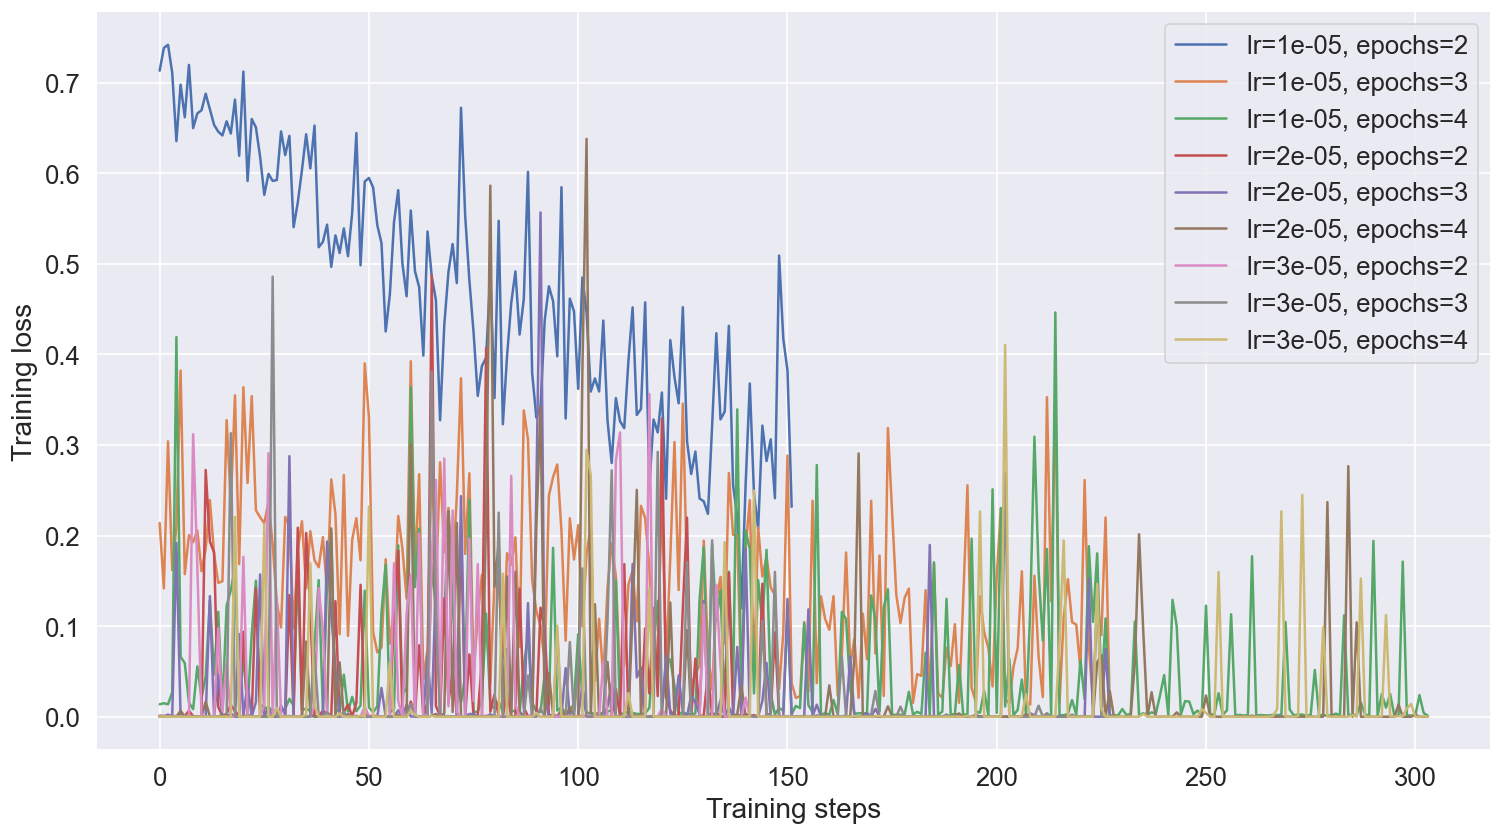

In [96]:
#This code uses two nested for loops to test different values of learning_rates and num_epochs. 
#For each combination, a new optimiser is created with the corresponding learning rate. 
#Then a for loop is performed on the number of epochs and the model is trained on each epoch. 
#The training loss is added to the epoch_train_losses list and plotted at the end of each combination. 
#The figure legend indicates the learning_rates and num_epochs values used for each curve.

# Create the graphic outside the loop.
plt.figure(figsize=(15,8),dpi=120)

for i, lr in enumerate(learning_rates):
    for j, epoch in enumerate(num_epochs):
        plt.plot(all_train_losses[i * len(num_epochs) + j], label=f"lr={lr}, epochs={epoch}")

plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.show()

In [182]:
# Creates an empty list to store the dictionaries
data = []

# Loop over learning_rates and num_epochs and add the corresponding values to the dictionary list.
for i, lr in enumerate(learning_rates):
    for j, epoch in enumerate(num_epochs):
        dic = {"learning_rate": lr, "num_epochs": epoch, "train_loss": all_train_losses[i * len(num_epochs) + j]}
        data.append(dic)

# Converts the list of dictionaries into a DataFrame
loss_df = pd.DataFrame(data)

loss_df['learning_rate'] = loss_df['learning_rate'].astype(str)

# Expands the "lost" column in the DataFrame
loss_df = loss_df.explode('train_loss').reset_index(drop=True)

loss_df['train_loss'] = loss_df['train_loss'].astype(float)

In [183]:
loss_df

,learning_rate,num_epochs,train_loss
0,1e-05,2,0.713206
1,1e-05,2,0.738303
2,1e-05,2,0.741798
3,1e-05,2,0.710854
4,1e-05,2,0.635410
...,...,...,...
2731,3e-05,4,0.014162
2732,3e-05,4,0.000159
2733,3e-05,4,0.000077
2734,3e-05,4,0.000498


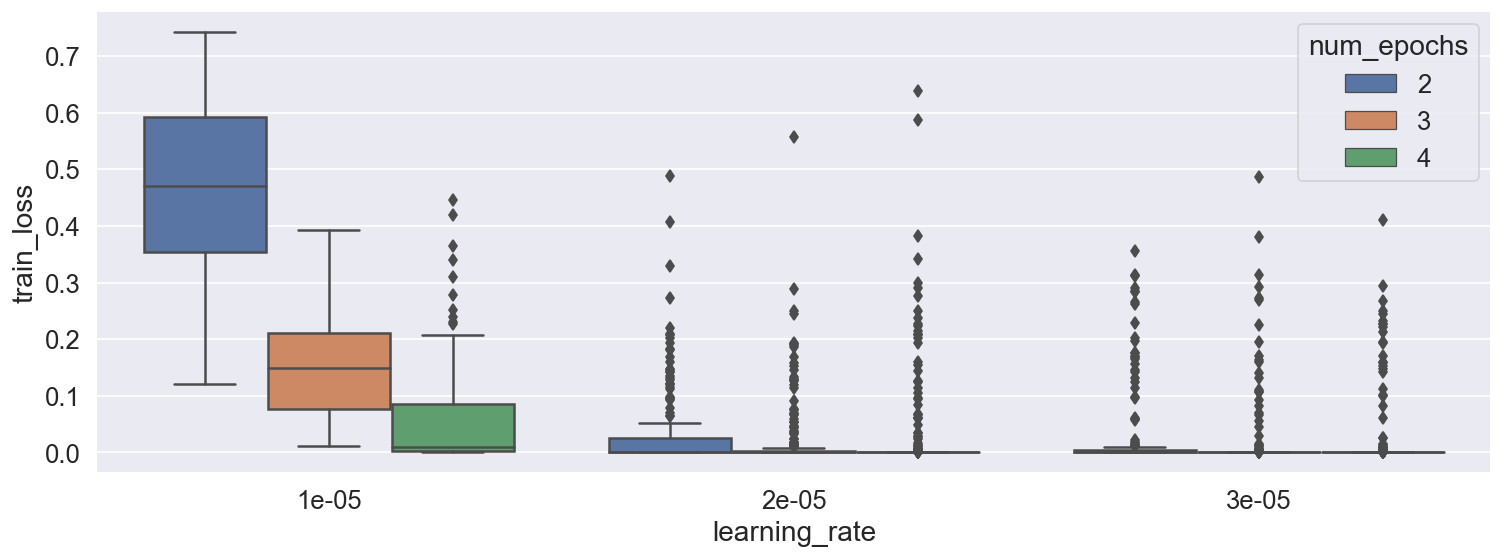

In [189]:
# Plot the boxplot using seaborn
plt.figure(figsize=(15,5),dpi=120)
sns.boxplot(x="learning_rate", y="train_loss",hue='num_epochs', data=loss_df, showfliers = True)
plt.show()

### BERT with Adamw Optimiser Final Model

In [85]:
#BertTokenizer is responsible for converting sentences from the training and test dataset into numerical vectors that 
#BERT can process, while BertForSequenceClassification is the pre-trained BERT model used in this classification task.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [86]:
#Extracts sentences and labels from the training and test data. 
#Sentences are stored in the variables train_sentences and test_sentences, 
#while labels are stored in the variables train_labels and test_labels.

train_sentences = train_data['tagged_in_context'].values
train_labels = train_data['label'].values

test_sentences = test_data['tagged_in_context'].values
test_labels = test_data['label'].values

In [398]:
#Counts the number of tokens per text

token_counts = []
for sentence in train_sentences:
    tokens = tokenizer.tokenize(sentence)
    num_tokens = len(tokens)
    token_counts.append(num_tokens)
    print(sentence)
    print(" ")
    print(tokens)
    print(" ")
    print("num_tokens: ", num_tokens)
    print("------")

No, <BOS> he <EOS> will not be confirmed. 
 
['no', ',', '<', 'bo', '##s', '>', 'he', '<', 'e', '##os', '>', 'will', 'not', 'be', 'confirmed', '.']
 
num_tokens:  16
------
This declassification effort <BOS> won’t make things any worse than they are for President Trump. <EOS> 
 
['this', 'dec', '##lass', '##ification', 'effort', '<', 'bo', '##s', '>', 'won', '’', 't', 'make', 'things', 'any', 'worse', 'than', 'they', 'are', 'for', 'president', 'trump', '.', '<', 'e', '##os', '>']
 
num_tokens:  27
------
The Obama administration misled the <BOS> American people <EOS> and Congress because they were desperate to get a deal with Iran, said Sen. 
 
['the', 'obama', 'administration', 'mis', '##led', 'the', '<', 'bo', '##s', '>', 'american', 'people', '<', 'e', '##os', '>', 'and', 'congress', 'because', 'they', 'were', 'desperate', 'to', 'get', 'a', 'deal', 'with', 'iran', ',', 'said', 'sen', '.']
 
num_tokens:  32
------
“It looks like we’re capturing the demise of this dark vortex, <BOS> a

Reporter Luke Harding’s latest article, claiming that Donald Trump’s disgraced former campaign manager Paul Manafort secretly visited Assange in Ecuador’s embassy in London on three occasions, <BOS> is so full of holes that even hardened opponents of Assange in the corporate media are struggling to stand by it <EOS>. 
 
['reporter', 'luke', 'harding', '’', 's', 'latest', 'article', ',', 'claiming', 'that', 'donald', 'trump', '’', 's', 'disgrace', '##d', 'former', 'campaign', 'manager', 'paul', 'mana', '##fort', 'secretly', 'visited', 'ass', '##ange', 'in', 'ecuador', '’', 's', 'embassy', 'in', 'london', 'on', 'three', 'occasions', ',', '<', 'bo', '##s', '>', 'is', 'so', 'full', 'of', 'holes', 'that', 'even', 'hardened', 'opponents', 'of', 'ass', '##ange', 'in', 'the', 'corporate', 'media', 'are', 'struggling', 'to', 'stand', 'by', 'it', '<', 'e', '##os', '>', '.']
 
num_tokens:  68
------
They already got Muslim gay communities.” He as well spoke of his support <BOS> for polygamy, an a

It was at exactly this time, however, that victims <BOS> from Argentina were attempting to get the <EOS> new pope’s attention. 
 
['it', 'was', 'at', 'exactly', 'this', 'time', ',', 'however', ',', 'that', 'victims', '<', 'bo', '##s', '>', 'from', 'argentina', 'were', 'attempting', 'to', 'get', 'the', '<', 'e', '##os', '>', 'new', 'pope', '’', 's', 'attention', '.']
 
num_tokens:  32
------
Homeland Security Advisory Council (he “resigned” in Sept. 2014 under mysterious circumstances), and Muslim Brotherhood-linked individuals like Huma Abedin serving as the right-hand woman of Hillary Clinton, <BOS> we need to bring in people who actually love America and want to protect it <EOS>. 
 
['homeland', 'security', 'advisory', 'council', '(', 'he', '“', 'resigned', '”', 'in', 'sept', '.', '2014', 'under', 'mysterious', 'circumstances', ')', ',', 'and', 'muslim', 'brotherhood', '-', 'linked', 'individuals', 'like', 'hum', '##a', 'abe', '##din', 'serving', 'as', 'the', 'right', '-', 'hand', 'w

Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued <BOS> since 2015 against the United States <EOS> government. 
 
['two', 'months', 'ago', ',', 'the', 'department', 'of', 'justice', 'quietly', 'offered', 'wilson', 'a', 'settlement', 'to', 'end', 'a', 'lawsuit', 'he', 'and', 'a', 'group', 'of', 'co', '-', 'plaintiffs', 'have', 'pursued', '<', 'bo', '##s', '>', 'since', '2015', 'against', 'the', 'united', 'states', '<', 'e', '##os', '>', 'government', '.']
 
num_tokens:  43
------
This <BOS> “contrite” papal apology didn’t fly well even with <EOS> the regular news reporters. 
 
['this', '<', 'bo', '##s', '>', '“', 'con', '##tri', '##te', '”', 'papal', 'apology', 'didn', '’', 't', 'fly', 'well', 'even', 'with', '<', 'e', '##os', '>', 'the', 'regular', 'news', 'reporters', '.']
 
num_tokens:  28
------
<BOS> There, I said it <EOS>! 
 
['<', 'bo', '##s', '>', 'there', ',', 'i', 'said', 'it', '<', 'e', 

Trump also seemed ready to back out on his new trade deal, which <BOS> is hardly a <EOS> deal for the US, with Mexico if they failed to stop the caravan. 
 
['trump', 'also', 'seemed', 'ready', 'to', 'back', 'out', 'on', 'his', 'new', 'trade', 'deal', ',', 'which', '<', 'bo', '##s', '>', 'is', 'hardly', 'a', '<', 'e', '##os', '>', 'deal', 'for', 'the', 'us', ',', 'with', 'mexico', 'if', 'they', 'failed', 'to', 'stop', 'the', 'caravan', '.']
 
num_tokens:  40
------
“TENEX continues to supply Iran with fuel through their <BOS> Russian company TVEL,” stated Campbell in a 2010 brief provided <EOS> to the FBI. 
 
['“', 'ten', '##ex', 'continues', 'to', 'supply', 'iran', 'with', 'fuel', 'through', 'their', '<', 'bo', '##s', '>', 'russian', 'company', 'tv', '##el', ',', '”', 'stated', 'campbell', 'in', 'a', '2010', 'brief', 'provided', '<', 'e', '##os', '>', 'to', 'the', 'fbi', '.']
 
num_tokens:  36
------
<BOS> In fiscal year 2016, ICE <EOS> conducted 240,255 removals nationwide. 
 
['<', 

['<', 'bo', '##s', '>', 'these', 'actions', ',', 'committed', 'by', 'more', 'than', 'a', 'few', ',', 'can', 'only', 'be', 'classified', 'as', 'evil', ',', 'evil', 'that', 'cries', 'out', 'for', 'justice', 'and', 'sin', 'that', 'must', 'be', 'cast', 'out', 'from', 'our', 'church', '<', 'e', '##os', '>', '.']
 
num_tokens:  42
------
This email leaked to Fox News and Breitbart News and is now likely to become a centerpiece in the case that Google is throwing its weight around to interfere in elections in the United States in <BOS> a partisan manner <EOS> against the duly elected President of the United States. 
 
['this', 'email', 'leaked', 'to', 'fox', 'news', 'and', 'br', '##eit', '##bar', '##t', 'news', 'and', 'is', 'now', 'likely', 'to', 'become', 'a', 'center', '##piece', 'in', 'the', 'case', 'that', 'google', 'is', 'throwing', 'its', 'weight', 'around', 'to', 'interfere', 'in', 'elections', 'in', 'the', 'united', 'states', 'in', '<', 'bo', '##s', '>', 'a', 'partisan', 'manner', '<'

The Black Robed regiment, were in fact, the preachers that went before the Forefathers in educating the colonies to resistance when it came to <BOS> the corrupt King <EOS> on the other side of the pond. 
 
['the', 'black', 'robe', '##d', 'regiment', ',', 'were', 'in', 'fact', ',', 'the', 'preacher', '##s', 'that', 'went', 'before', 'the', 'fore', '##fat', '##hers', 'in', 'educating', 'the', 'colonies', 'to', 'resistance', 'when', 'it', 'came', 'to', '<', 'bo', '##s', '>', 'the', 'corrupt', 'king', '<', 'e', '##os', '>', 'on', 'the', 'other', 'side', 'of', 'the', 'pond', '.']
 
num_tokens:  49
------
And the Lord said, If I find in Sodom fifty <BOS> righteous <EOS> within the city, then I will spare all the place for their sakes. 
 
['and', 'the', 'lord', 'said', ',', 'if', 'i', 'find', 'in', 'so', '##dom', 'fifty', '<', 'bo', '##s', '>', 'righteous', '<', 'e', '##os', '>', 'within', 'the', 'city', ',', 'then', 'i', 'will', 'spare', 'all', 'the', 'place', 'for', 'their', 'sake', '##s', 

“Anonymous letters with no name and no return address are now being treated as national news.” Taking a shot at Stormy Daniels attorney Michael Avenatti, Hatch said “<BOS> porn star lawyers with facially implausible claims <EOS> are driving the news cycle.” 
 
['“', 'anonymous', 'letters', 'with', 'no', 'name', 'and', 'no', 'return', 'address', 'are', 'now', 'being', 'treated', 'as', 'national', 'news', '.', '”', 'taking', 'a', 'shot', 'at', 'stormy', 'daniels', 'attorney', 'michael', 'ave', '##nat', '##ti', ',', 'hatch', 'said', '“', '<', 'bo', '##s', '>', 'porn', 'star', 'lawyers', 'with', 'facial', '##ly', 'imp', '##laus', '##ible', 'claims', '<', 'e', '##os', '>', 'are', 'driving', 'the', 'news', 'cycle', '.', '”']
 
num_tokens:  59
------
Florida should be called and called now unless the <BOS> GOP wants to Florida and Georgia stolen <EOS> the way they are stealing House seats. 
 
['florida', 'should', 'be', 'called', 'and', 'called', 'now', 'unless', 'the', '<', 'bo', '##s', '>',

Ebola <BOS> virus disease <EOS> (EVD) was first discovered in 1976 in two simultaneous outbreaks. 
 
['e', '##bola', '<', 'bo', '##s', '>', 'virus', 'disease', '<', 'e', '##os', '>', '(', 'ev', '##d', ')', 'was', 'first', 'discovered', 'in', '1976', 'in', 'two', 'simultaneous', 'outbreak', '##s', '.']
 
num_tokens:  27
------
In 2015, Carmelite monasteries received a questionnaire <BOS> from the <EOS> Father General Fr. 
 
['in', '2015', ',', 'carmel', '##ite', 'monasteries', 'received', 'a', 'question', '##naire', '<', 'bo', '##s', '>', 'from', 'the', '<', 'e', '##os', '>', 'father', 'general', 'fr', '.']
 
num_tokens:  24
------
I added that it would be <BOS> salutary if, for once, ecclesiastical authority would intervene before the civil authorities <EOS> and, if possible, before the scandal had broken out in the press. 
 
['i', 'added', 'that', 'it', 'would', 'be', '<', 'bo', '##s', '>', 'sal', '##uta', '##ry', 'if', ',', 'for', 'once', ',', 'ecclesiastical', 'authority', 'would', 

['<', 'bo', '##s', '>', 'take', 'for', 'example', 'luke', 'harding', 'of', 'the', 'guardian', 'who', 'just', 'published', 'a', 'book', 'titled', 'col', '##lusion', ':', 'secret', 'meetings', ',', 'dirty', 'money', ',', 'and', 'how', 'russia', 'helped', 'donald', 'trump', 'win', '.', 'he', 'was', 'taken', 'apart', 'in', 'a', 'real', 'news', 'interview', '(', 'vi', '##d', ')', 'about', 'the', 'book', '.', 'the', 'interview', '##er', 'pointed', 'out', 'that', 'there', 'is', 'absolutely', 'no', 'evidence', 'in', 'the', 'book', 'to', 'support', 'its', 'claims', '.', 'when', 'asked', 'for', 'any', 'proof', 'for', 'his', 'assertion', 'harding', 'defensive', '##ly', 'says', 'that', 'he', 'is', 'just', '"', 'storytelling', '"', '-', 'in', 'other', 'words', ':', 'it', 'is', 'fiction', '.', 'harding', 'earlier', 'wrote', 'a', 'book', 'about', 'edward', 'snow', '##den', 'which', 'was', 'a', 'similar', 'sham', '.', 'julian', 'ass', '##ange', 'called', 'it', '"', 'a', 'hack', 'job', 'in', 'the', 'pu

Paddock shot the guard at 9:59 p.m. local time, Lombardo said, shortly before raining down bullets on the Route 91 Harvest festival in an attack that began at <BOS> 10:05 p.m. <EOS> and lasted 10 minutes. 
 
['pad', '##dock', 'shot', 'the', 'guard', 'at', '9', ':', '59', 'p', '.', 'm', '.', 'local', 'time', ',', 'lombard', '##o', 'said', ',', 'shortly', 'before', 'raining', 'down', 'bullets', 'on', 'the', 'route', '91', 'harvest', 'festival', 'in', 'an', 'attack', 'that', 'began', 'at', '<', 'bo', '##s', '>', '10', ':', '05', 'p', '.', 'm', '.', '<', 'e', '##os', '>', 'and', 'lasted', '10', 'minutes', '.']
 
num_tokens:  57
------
They filed a case in the Federal courts and were assigned to a Kritarch, Patti Saris, <BOS> who apparently thinks she runs immigration policy <EOS>, even after aliens have had their day in court. 
 
['they', 'filed', 'a', 'case', 'in', 'the', 'federal', 'courts', 'and', 'were', 'assigned', 'to', 'a', 'k', '##rita', '##rch', ',', 'patti', 'sar', '##is', ',', '

In [388]:
df_token_counts = pd.DataFrame(token_counts)
df_token_counts.describe()

,0
count,2414.000000
mean,43.159072
std,63.791046
min,10.000000
25%,26.000000
50%,36.000000
75%,51.000000
max,1946.000000


(0.0, 250.0)

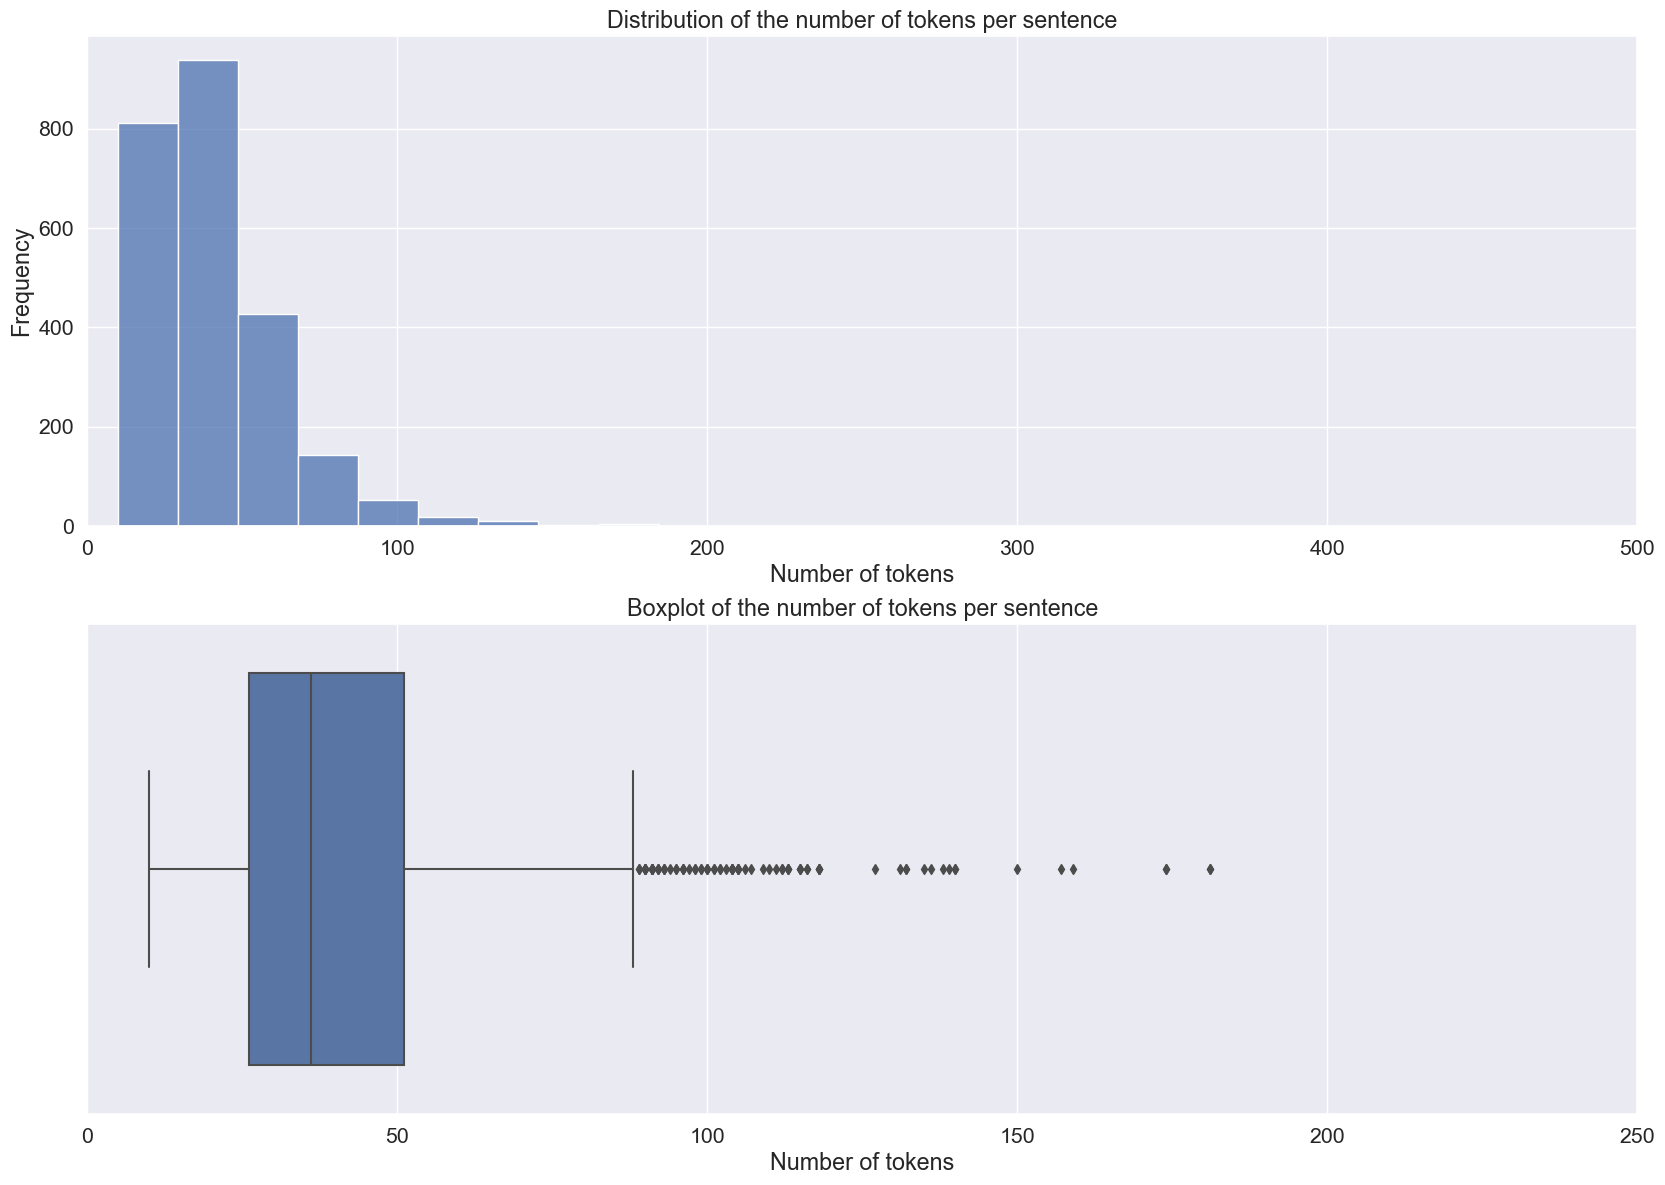

In [107]:
#creates a histogram and boxplot of the number of tokens per text

fig,axs = plt.subplots(nrows=2, figsize=(20,14))
# Creating a distribution chart with Seaborn
sns.histplot(token_counts, kde=False, bins=100,ax=axs[0])
sns.boxplot(x=token_counts,showfliers=True, ax=axs[1])

# Add labels and title to chart
axs[0].set_xlabel('Number of tokens')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of the number of tokens per sentence')
axs[0].set_xlim(0, 500)
axs[1].set_xlabel('Number of tokens')
axs[1].set_title('Boxplot of the number of tokens per sentence')
axs[1].set_xlim(0, 250)

In [89]:
#Creates a label_map dictionary that maps the original labels in the dataset 
#(such as "flag_waving" or "name_calling,labeling") to the binary labels 0 (advertising) and 1 (non-advertising).

label_map = {'flag_waving': 0, 'appeal_to_fear_prejudice': 0, 'causal_simplification': 0, 'doubt': 0, 'exaggeration,minimisation': 0, 'loaded_language': 0, 'name_calling,labeling': 0, 'repetition': 0, 'not_propaganda': 1,'causal_oversimplification': 0}

train_labels = [label_map[label] for label in train_labels]

test_labels = [label_map[label] for label in test_labels]

In [90]:
#Defines the maximum length of sequences using the max_length variable.
max_length = 100

#Encodes sentences from the training and test dataset using the BertTokenizer tokeniser, 
#limiting the maximum length of the sequence to max_length. The batch_encode_plus function is 
#used to encode multiple sentences efficiently in a single step.

train_encodings = tokenizer.batch_encode_plus(train_sentences, max_length=max_length, padding=True, truncation=True)
test_encodings = tokenizer.batch_encode_plus(test_sentences, max_length=max_length, padding=True, truncation=True)

In [91]:
#Divides training and test data into inputs, attention masks and labels, using the dictionary keys input_ids, 
#attention_mask and labels.

train_inputs = train_encodings['input_ids']
train_masks = train_encodings['attention_mask']
train_labels = torch.tensor(train_labels)

test_inputs = test_encodings['input_ids']
test_masks = test_encodings['attention_mask']
test_labels = torch.tensor(test_labels)

In [404]:
df_train_encodings = pd.DataFrame(train_inputs)
df_test_encodings = pd.DataFrame(test_inputs)

df_train_encodings

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,101,2053,1010,1026,8945,2015,1028,2002,1026,1041,...,0,0,0,0,0,0,0,0,0,0
1,101,2023,11703,27102,9031,3947,1026,8945,2015,1028,...,0,0,0,0,0,0,0,0,0,0
2,101,1996,8112,3447,28616,3709,1996,1026,8945,2015,...,0,0,0,0,0,0,0,0,0,0
3,101,1523,2009,3504,2066,2057,1521,2128,11847,1996,...,0,0,0,0,0,0,0,0,0,0
4,101,1026,8945,2015,1028,3295,1024,2225,2121,3077,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,101,1026,8945,2015,1028,2057,2490,1998,9120,1026,...,0,0,0,0,0,0,0,0,0,0
2410,101,2248,9593,2943,4034,1006,24264,5243,1007,2472,...,1055,4517,3450,1012,102,0,0,0,0,0
2411,101,2054,2038,2042,2589,1024,2045,2038,2042,2147,...,0,0,0,0,0,0,0,0,0,0
2412,101,2023,2003,1026,8945,2015,1028,1996,2375,1997,...,0,0,0,0,0,0,0,0,0,0


In [92]:
#In the BERT model, each text input is decomposed into tokens and then converted into a token array that is 
#fed to the neural network. The dimension [2414, 128] refers to the shape of the resulting token matrix, 
#where 2414 is the maximum number of tokens allowed in an input sequence and 128 is the dimension of the 
#embedding space of each token.

#In other words, the tensor is a matrix of 2414 rows and 128 columns where each row represents a token
#and each column represents a dimension in the embedding space. This matrix is the numerical representation of 
#the input sequence and is what is fed to the BERT neural network to perform the corresponding processing and learning task.

train_inputs_tensor = torch.tensor(train_inputs)
train_masks_tensor = torch.tensor(train_masks)

dim_train_inputs_tensor = train_inputs_tensor.size()
dim_train_masks_tensor = train_masks_tensor.size()
dim_train_labels = train_labels.size()

print(dim_train_inputs_tensor)
print(dim_train_masks_tensor)
print(dim_train_labels)

torch.Size([2414, 100])
torch.Size([2414, 100])
torch.Size([2414])


In [386]:
train_inputs_tensor

tensor([[  101,  2053,  1010,  ...,     0,     0,     0],
        [  101,  2023, 11703,  ...,     0,     0,     0],
        [  101,  1996,  8112,  ...,     0,     0,     0],
        ...,
        [  101,  2054,  2038,  ...,     0,     0,     0],
        [  101,  2023,  2003,  ...,     0,     0,     0],
        [  101,  1999,  2009,  ...,     0,     0,     0]])

In [93]:
batch_size = 32

#Creates TensorDatasets from inputs, attention masks and labels.
train_dataset = TensorDataset(train_inputs_tensor, torch.tensor(train_masks), train_labels)
#Creates DataLoader dataloaders from TensorDatasets, allowing efficient loading of data in batch_size batches.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [190]:
#Create the Adamw optimisation model

learning_rate = 3e-5
num_epochs = 4

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

train_losses = [] # List to store the training loss for each step.

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        inputs = batch[0].to('cpu')
        masks = batch[1].to('cpu')
        labels = batch[2].to('cpu')

        outputs = model(inputs, attention_mask=masks, labels=labels)

        loss = outputs[0]
        total_loss += loss.item()
        train_losses.append(loss.item()) # Adds the loss of each iteration to the list

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print("Epoch", epoch+1)
    print("Training Loss:", avg_train_loss)
    print("------------.....")


C:\Users\FelipeMartin\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Training Loss: 0.01208691960967874
------------.....
Epoch 2
Training Loss: 0.005672452190430321
------------.....
Epoch 3
Training Loss: 0.00435290603684878
------------.....
Epoch 4
Training Loss: 0.046540661269510133
------------.....


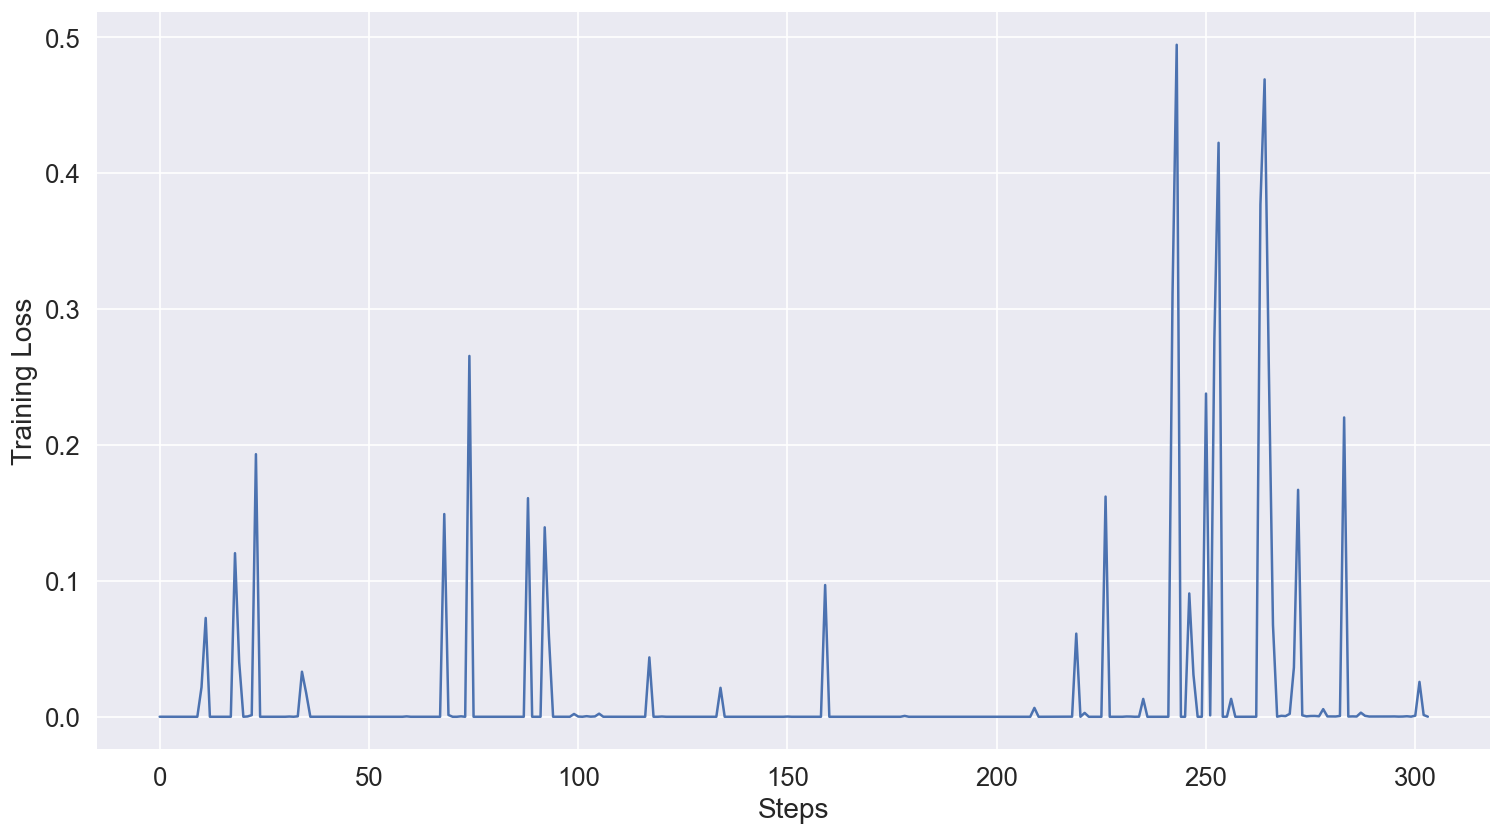

In [193]:
#This code will create a graph of steps vs. training loss. 
#Each point on the graph will represent the loss of one iteration of the training loop.

plt.figure(figsize=(15,8),dpi=120)
# Plotting the steps vs training loss chart
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.show()

In [13]:
#Evaluates the model on the test data by calculating the average prediction accuracy on the test batches 
#and then printing the overall average prediction accuracy of the model.

model.eval()
total_accuracy = 0

for batch in test_dataloader:
    inputs = batch[0].to('cpu')
    masks = batch[1].to('cpu')
    labels = batch[2].to('cpu')

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)

    logits = outputs[0]
    predictions = torch.argmax(logits, dim=1)

    accuracy = torch.sum(predictions == labels).item() / len(labels)
    total_accuracy += accuracy

avg_test_accuracy = total_accuracy / len(test_dataloader)

print("Test Accuracy:", avg_test_accuracy)

Test Accuracy: 0.930921052631579


In [15]:
true_labels = []
predicted_labels = []

for batch in test_dataloader:
    inputs = batch[0].to('cpu')
    masks = batch[1].to('cpu')
    labels = batch[2].to('cpu')

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)

    logits = outputs[0]
    predictions = torch.argmax(logits, dim=1)

    true_labels += labels.tolist()
    predicted_labels += predictions.tolist()

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[264  15]
 [ 27 274]]


In [17]:
#Prints a classification report showing the accuracy, #recall and F1 score for each classification tag in the test data, 
#recovery and F1 score for each classification label in the test data.
print('1 = Not propaganda\n0 = Propaganda' )

print(classification_report(true_labels, predicted_labels))

1 = Not propaganda
0 = Propaganda
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       279
           1       0.95      0.91      0.93       301

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580



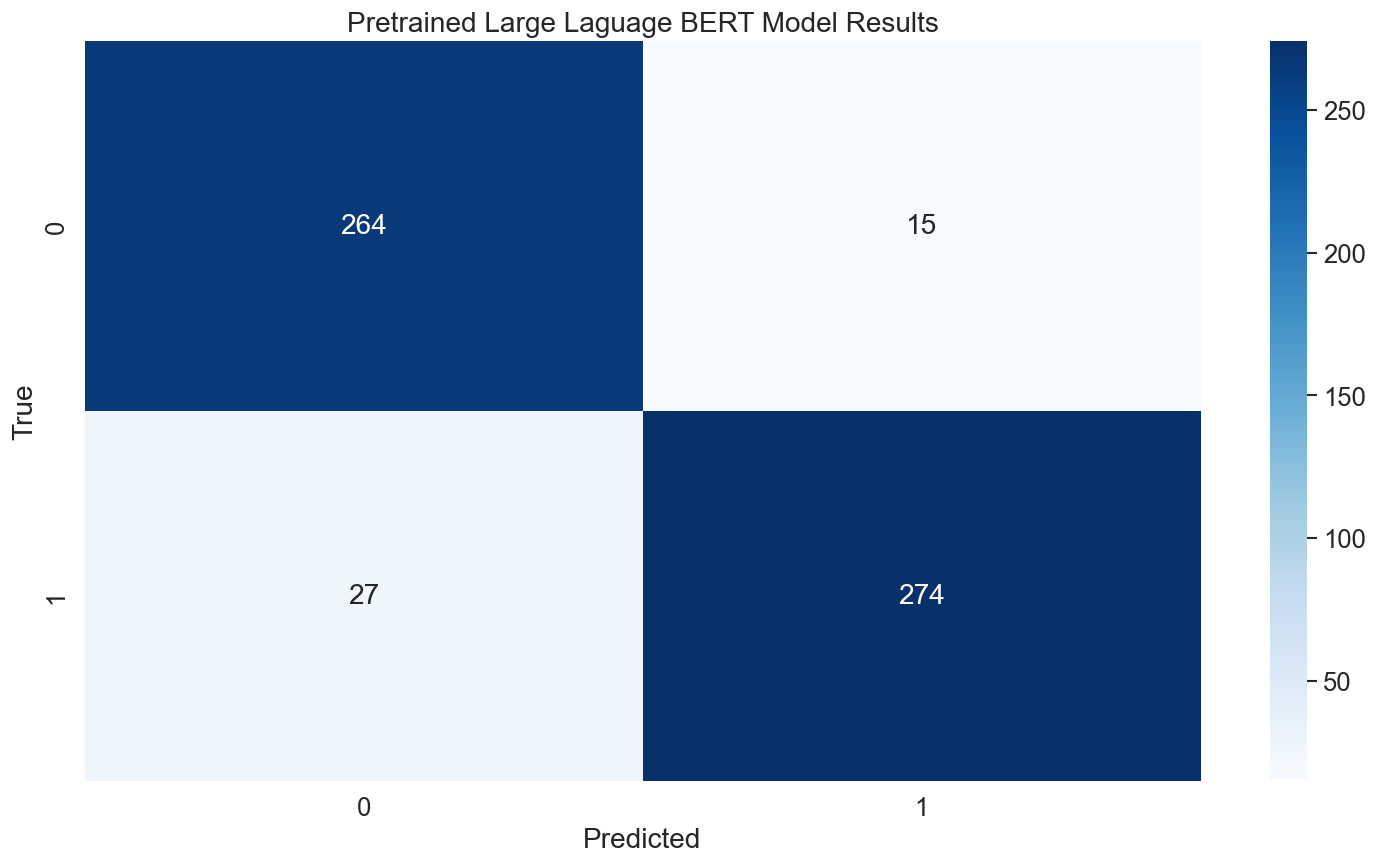

In [409]:
# Create a heatmap with the confusion matrix
sns.set(font_scale=1.4) 
plt.figure(figsize=(15,8),dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# Labelling of axes
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Pretrained Large Laguage BERT Model Results")
#Show the graph
plt.show()

# Propaganda Methods Classification  <a class="anchor" id="4-bullet"></a>

## Word2Vec +  Decision Trees <a class="anchor" id="4.1-bullet"></a>

### Hyperparameter tuning

In [325]:
#Create a function to plot the confusion matrix for model evaluation

activityIDdict = {0: 'propaganda', 1:'not_propaganda'}

def plot_confusion_matrix(model,X_test,y_test,title='',is_ml=False, labels={}):
    
  ticks = list(map(lambda x : activityIDdict[x], np.unique(y_test).tolist())) if labels=={} else labels.values()
  preds = model.predict(X_test)
  pred_cat = preds if is_ml else np.argmax(preds,axis=1)
  print('model accuracy on test set is: {0:.2f}%'.format(accuracy_score(y_test,pred_cat)*100))
  plt.figure(figsize=(15,8),dpi=120)
  sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Blues',annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

In [26]:
#Delete label = not_propaganda from train and test dataset
train_data = train_data.drop(train_data[train_data['label'] == 'not_propaganda'].index)
test_data = test_data.drop(test_data[test_data['label'] == 'not_propaganda'].index)

label_map = {'flag_waving': 0, 'appeal_to_fear_prejudice': 1, 'causal_simplification': 2, 
             'doubt': 3, 'exaggeration,minimisation': 4, 'loaded_language': 5, 'name_calling,labeling': 6, 
             'repetition': 7, 'causal_oversimplification': 9}

# Preprocess the text data
stopwords = nltk.corpus.stopwords.words('english')
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords and token.isalnum()]
    return ' '.join(tokens)

train_data['tagged_in_context'] = train_data['tagged_in_context'].apply(preprocess)
test_data['tagged_in_context'] = test_data['tagged_in_context'].apply(preprocess)

# Train a word2vec model on the training corpus
sentences = [s.split() for s in train_data['tagged_in_context']]
model = Word2Vec(sentences, vector_size=200, min_count=10, window=10)


# Convert the sentences to numerical vectors using the word2vec model
def senttovec(sent):
    vec = []
    for word in sent.split():
        if word in model.wv.key_to_index:
            vec.append(model.wv.get_vector(word))
    if vec:
        vec = sum(vec) / len(vec)
    else:
        vec = [0] * 100
    return vec

Xtrain = train_data['tagged_in_context'].apply(senttovec)
Xtest = test_data['tagged_in_context'].apply(senttovec)
Xtest=list(Xtest)

ytrain = train_data['label'].values

ytrain = [label_map[label] for label in ytrain]


ytest = test_data['label'].values
ytest = [label_map[label] for label in ytest]


# Train Decision Tree classifier on vectors
clf = DecisionTreeClassifier()

# Define hyperparameters to test

param_grid = {'max_depth': range(1, 11),
              'criterion': ['entropy', 'gini']}

# Use GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(list(Xtrain), ytrain)

# Print best hyperparameters
print("Best hyperparameters: {}".format(grid_search.best_params_))

# Make predictions on test data using best hyperparameters
ypred = grid_search.predict(Xtest)

print('1 = Not propaganda\n0 = Propaganda')
cm = classification_report(ytest, ypred)
print(cm)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 7}
1 = Not propaganda
0 = Propaganda
              precision    recall  f1-score   support

           0       0.20      0.05      0.08        39
           1       0.18      0.49      0.26        43
           3       0.13      0.13      0.13        38
           4       0.07      0.07      0.07        28
           5       0.15      0.14      0.14        37
           6       0.10      0.03      0.05        31
           7       0.19      0.22      0.21        32
           9       0.00      0.00      0.00        31

    accuracy                           0.15       279
   macro avg       0.13      0.14      0.12       279
weighted avg       0.13      0.15      0.12       279



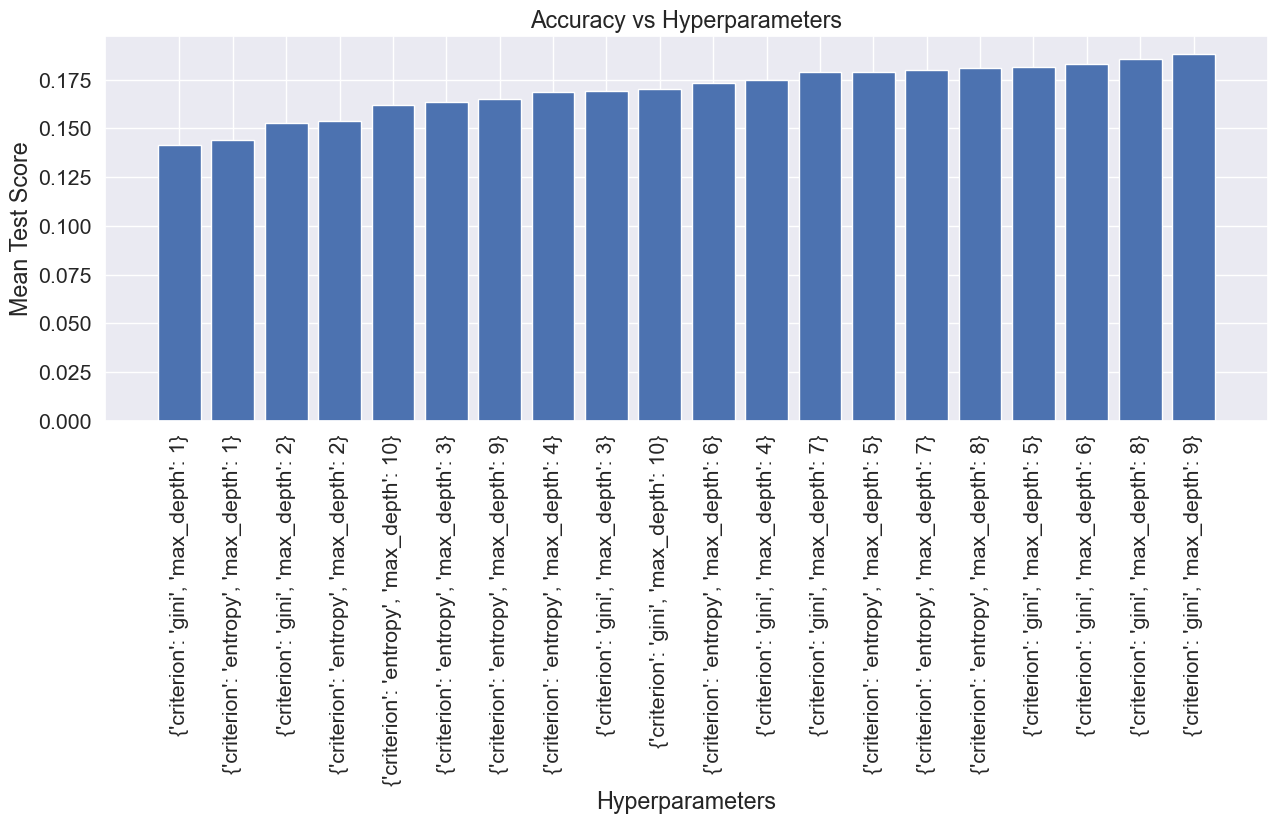

In [756]:
# Get the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

results_sorted = results.sort_values(by='mean_test_score', ascending=True)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(15,5))

# Create a stacked bar chart of the average cross-validation score for each hyperparameter combination.
ax.bar(results_sorted['params'].apply(str), results_sorted['mean_test_score'])

# Set axis labels and title
ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Mean Test Score')
ax.set_title('Accuracy vs Hyperparameters')

# Rotate x-axis labels so that they do not overlap
plt.xticks(rotation=90)

# Show the graph
plt.show()

## Word2Vec +  Decision Trees Final Model

In [764]:
#Delete label = not_propaganda from train and test dataset
train_data = train_data.drop(train_data[train_data['label'] == 'not_propaganda'].index)
test_data = test_data.drop(test_data[test_data['label'] == 'not_propaganda'].index)

label_map = {'flag_waving': 0, 'appeal_to_fear_prejudice': 1, 'causal_simplification': 2, 'doubt': 3, 'exaggeration,minimisation': 4, 'loaded_language': 5, 'name_calling,labeling': 6, 'repetition': 7, 'causal_oversimplification': 9}

# Preprocess the text data
#Convert text to lower case.
#Divides text into tokens (individual words) using the NLTK (Natural Language Toolkit) word tokeniser.
#Filter the tokens to remove English stopwords and non-alphanumeric characters.
#Join the remaining tokens into a text string separated by a space.
stopwords = nltk.corpus.stopwords.words('english')
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords and token.isalnum()]
    return ' '.join(tokens)

train_data['tagged_in_context'] = train_data['tagged_in_context'].apply(preprocess)
test_data['tagged_in_context'] = test_data['tagged_in_context'].apply(preprocess)

# Train a word2vec model on the training corpus
sentences = [s.split() for s in train_data['tagged_in_context']]
model = Word2Vec(sentences, vector_size=200, min_count=10,window=10)
#model = Word2Vec(corpus,  vector_size=100, window=5, min_count=1, workers=4)

# Convert the sentences to numerical vectors using the word2vec model
def sent_to_vec(sent):
    vec = []
    for word in sent.split():
        if word in model.wv.key_to_index:
            vec.append(model.wv.get_vector(word))
    if vec:
        vec = sum(vec) / len(vec)
    else:
        vec = [0] * 100
    return vec

X_train = train_data['tagged_in_context'].apply(sent_to_vec)
X_test = test_data['tagged_in_context'].apply(sent_to_vec)
X_test=list(X_test)

y_train = train_data['label'].values
y_train = [label_map[label] for label in y_train]

y_test = test_data['label'].values
y_test = [label_map[label] for label in y_test]

# Train Decision Tree classifier on vectors
clf = DecisionTreeClassifier(criterion='gini',max_depth=9)
clf.fit(list(X_train), y_train)

# Evaluate the model
y_pred = clf.predict(X_test)

cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.25      0.28      0.27        39
           1       0.16      0.16      0.16        43
           3       0.30      0.21      0.25        38
           4       0.18      0.29      0.22        28
           5       0.23      0.30      0.26        37
           6       0.18      0.19      0.19        31
           7       0.30      0.22      0.25        32
           9       0.13      0.06      0.09        31

    accuracy                           0.22       279
   macro avg       0.22      0.21      0.21       279
weighted avg       0.22      0.22      0.21       279



model accuracy on test set is: 21.51%


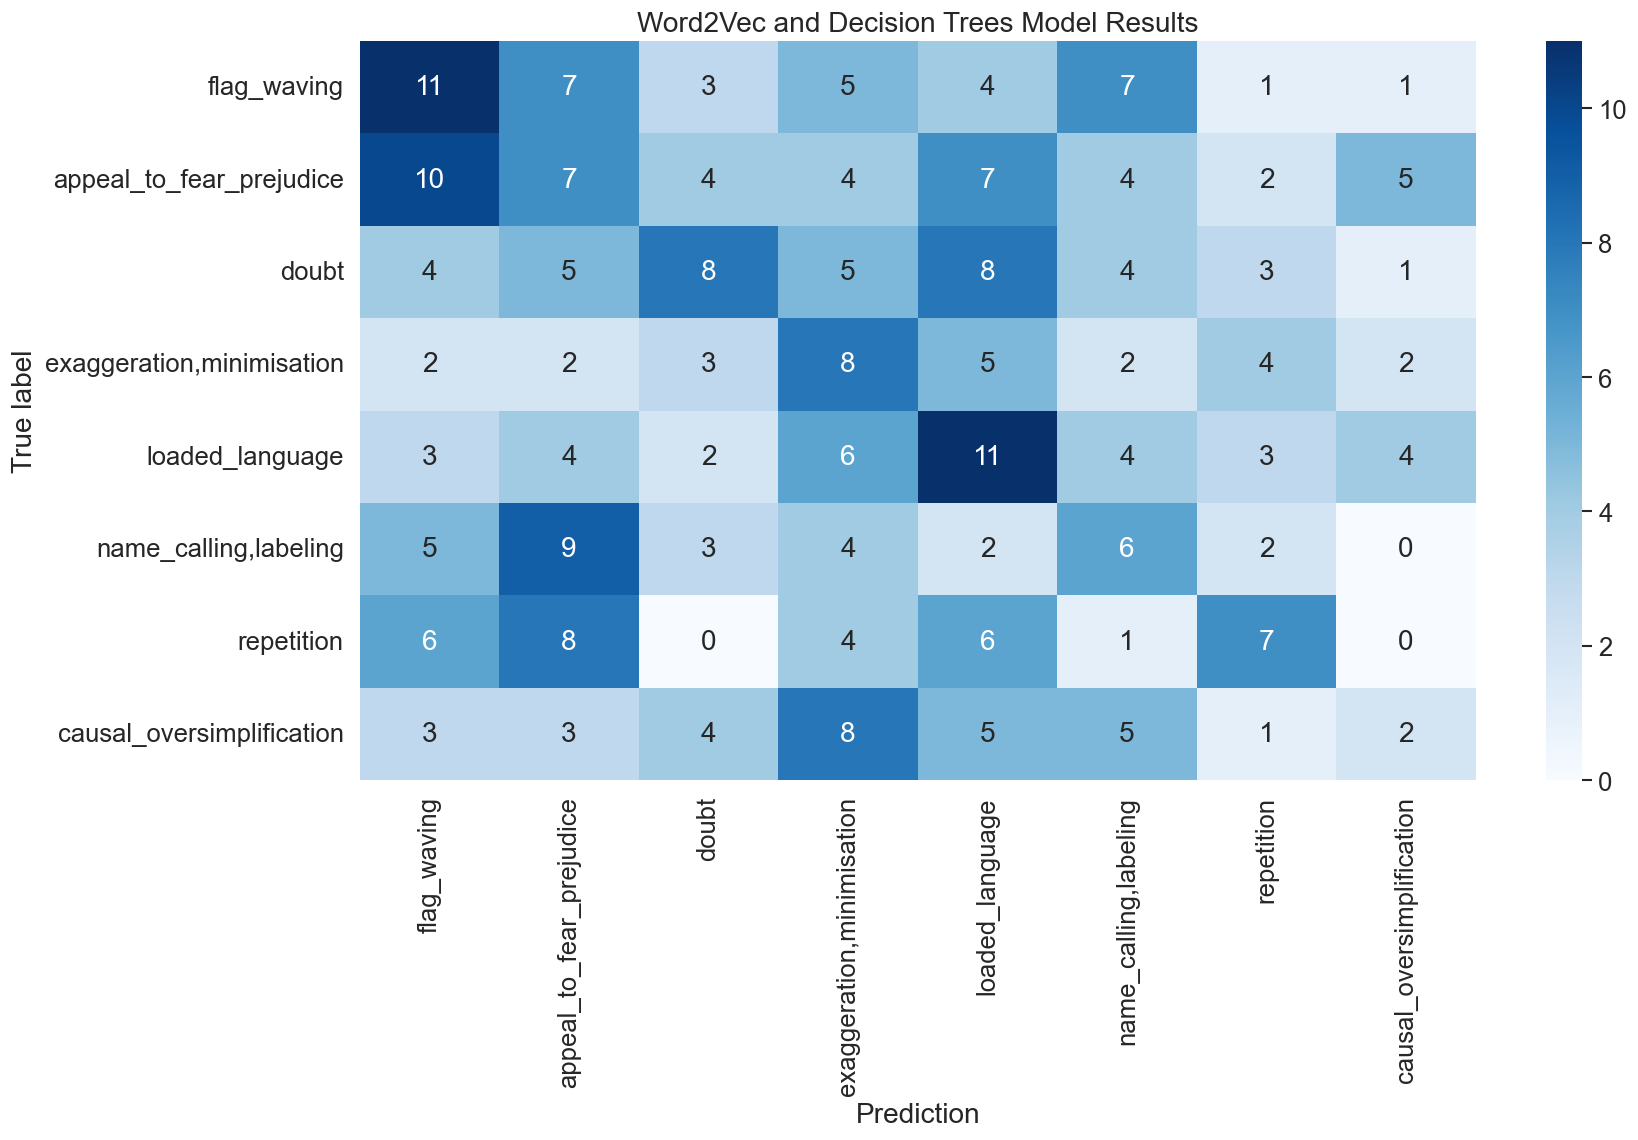

In [765]:
plot_confusion_matrix(clf,X_test,y_test,"Word2Vec and Decision Trees Model Results",is_ml=True)

## BERT + ADAMW optimiser <a class="anchor" id="4.2-bullet"></a>


In [679]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [680]:
#Delete label = not_propaganda from train and test dataset
train_data = train_data.drop(train_data[train_data['label'] == 'not_propaganda'].index)
test_data = test_data.drop(test_data[test_data['label'] == 'not_propaganda'].index)

train_sentences = train_data['tagged_in_context'].values
train_labels = train_data['label'].values

test_sentences = test_data['tagged_in_context'].values
test_labels = test_data['label'].values

In [681]:
label_map = {'flag_waving': 0, 'appeal_to_fear_prejudice': 1, 'causal_simplification': 2, 'doubt': 3, 'exaggeration,minimisation': 4, 'loaded_language': 5, 'name_calling,labeling': 6, 'repetition': 7, 'not_propaganda': 8,'causal_oversimplification': 9}

train_labels = [label_map[label] for label in train_labels]

test_labels = [label_map[label] for label in test_labels]

In [682]:
#Defines the maximum length of sequences using the max_length variable.
max_length = 100

train_encodings = tokenizer.batch_encode_plus(train_sentences, max_length=max_length, padding=True, truncation=True)
test_encodings = tokenizer.batch_encode_plus(test_sentences, max_length=max_length, padding=True, truncation=True)

In [683]:
train_inputs = train_encodings['input_ids']
train_masks = train_encodings['attention_mask']
train_labels = torch.tensor(train_labels)

test_inputs = test_encodings['input_ids']
test_masks = test_encodings['attention_mask']
test_labels = torch.tensor(test_labels)

In [684]:
train_inputs_tensor = torch.tensor(train_inputs)
train_masks_tensor = torch.tensor(train_masks)

dim_train_inputs_tensor = train_inputs_tensor.size()
dim_train_masks_tensor = train_masks_tensor.size()
dim_train_labels = train_labels.size()

print(dim_train_inputs_tensor)
print(dim_train_masks_tensor)
print(dim_train_labels)

torch.Size([1223, 100])
torch.Size([1223, 100])
torch.Size([1223])


In [685]:
batch_size = 32
train_dataset = TensorDataset(train_inputs_tensor, torch.tensor(train_masks), train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [686]:
#Create the Adamw optimisation model

learning_rate = 3e-5
num_epochs = 4

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

train_losses = []    # List to store the training loss for each step.

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        inputs = batch[0].to('cpu')
        masks = batch[1].to('cpu')
        labels = batch[2].to('cpu')

        outputs = model(inputs, attention_mask=masks, labels=labels)

        loss = outputs[0]
        total_loss += loss.item()
        train_losses.append(loss.item()) # Add the loss of each iteration to the list.

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print("Epoch", epoch+1)
    print("Training Loss:", avg_train_loss)
    print("------------.....")

C:\Users\FelipeMartin\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Training Loss: 2.11000308012351
------------.....
Epoch 2
Training Loss: 1.8469690206723335
------------.....
Epoch 3
Training Loss: 1.601646126844944
------------.....
Epoch 4
Training Loss: 1.310381653981331
------------.....


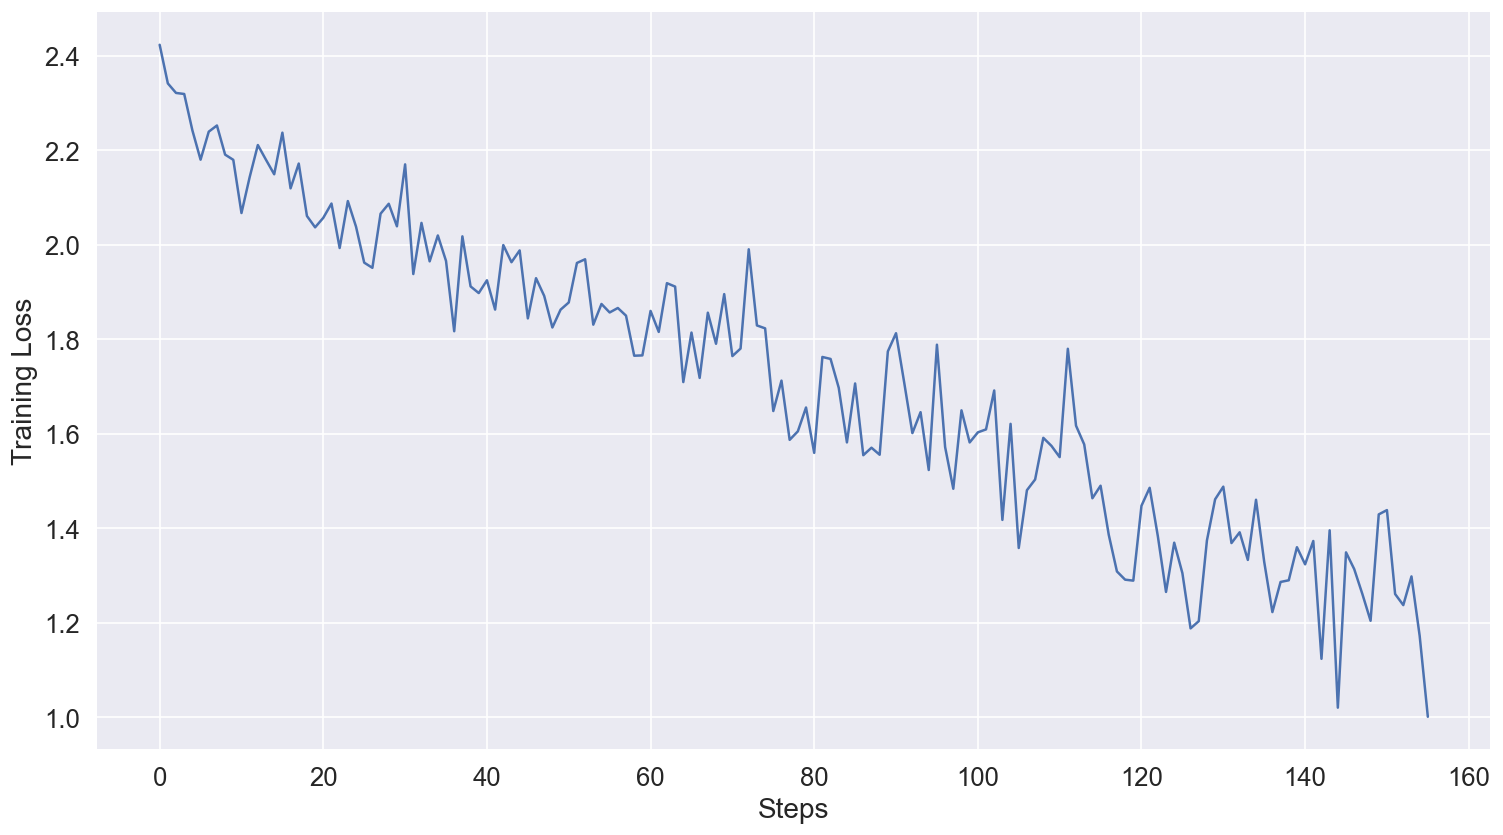

In [687]:
# Plotting the steps vs training loss chart
plt.figure(figsize=(15,8),dpi=120)
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.show()

In [688]:
model.eval()
total_accuracy = 0

for batch in test_dataloader:
    inputs = batch[0].to('cpu')
    masks = batch[1].to('cpu')
    labels = batch[2].to('cpu')

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)

    logits = outputs[0]
    predictions = torch.argmax(logits, dim=1)

    accuracy = torch.sum(predictions == labels).item() / len(labels)
    total_accuracy += accuracy

avg_test_accuracy = total_accuracy / len(test_dataloader)

print("Test Accuracy:", avg_test_accuracy)

Test Accuracy: 0.4773550724637681


In [689]:
true_labels = []
predicted_labels = []

for batch in test_dataloader:
    inputs = batch[0].to('cpu')
    masks = batch[1].to('cpu')
    labels = batch[2].to('cpu')

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)

    logits = outputs[0]
    predictions = torch.argmax(logits, dim=1)

    true_labels += labels.tolist()
    predicted_labels += predictions.tolist()

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[31  5  0  0  0  1  0  2]
 [ 4 29  1  1  0  1  1  6]
 [ 2  1 20  1  0  0  0 14]
 [ 8  5  0  7  3  2  0  3]
 [10  4  1  4  8  7  2  1]
 [ 2  3  2  5  6 13  0  0]
 [12  4  0  3  4  4  5  0]
 [ 3  4  5  0  0  0  0 19]]


In [690]:
#Prints a classification report showing the accuracy, #recall and F1 score for each classification tag in the test data, 
#recall and F1 score for each classification label in the test data.

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.43      0.79      0.56        39
           1       0.53      0.67      0.59        43
           3       0.69      0.53      0.60        38
           4       0.33      0.25      0.29        28
           5       0.38      0.22      0.28        37
           6       0.46      0.42      0.44        31
           7       0.62      0.16      0.25        32
           9       0.42      0.61      0.50        31

    accuracy                           0.47       279
   macro avg       0.48      0.46      0.44       279
weighted avg       0.49      0.47      0.45       279



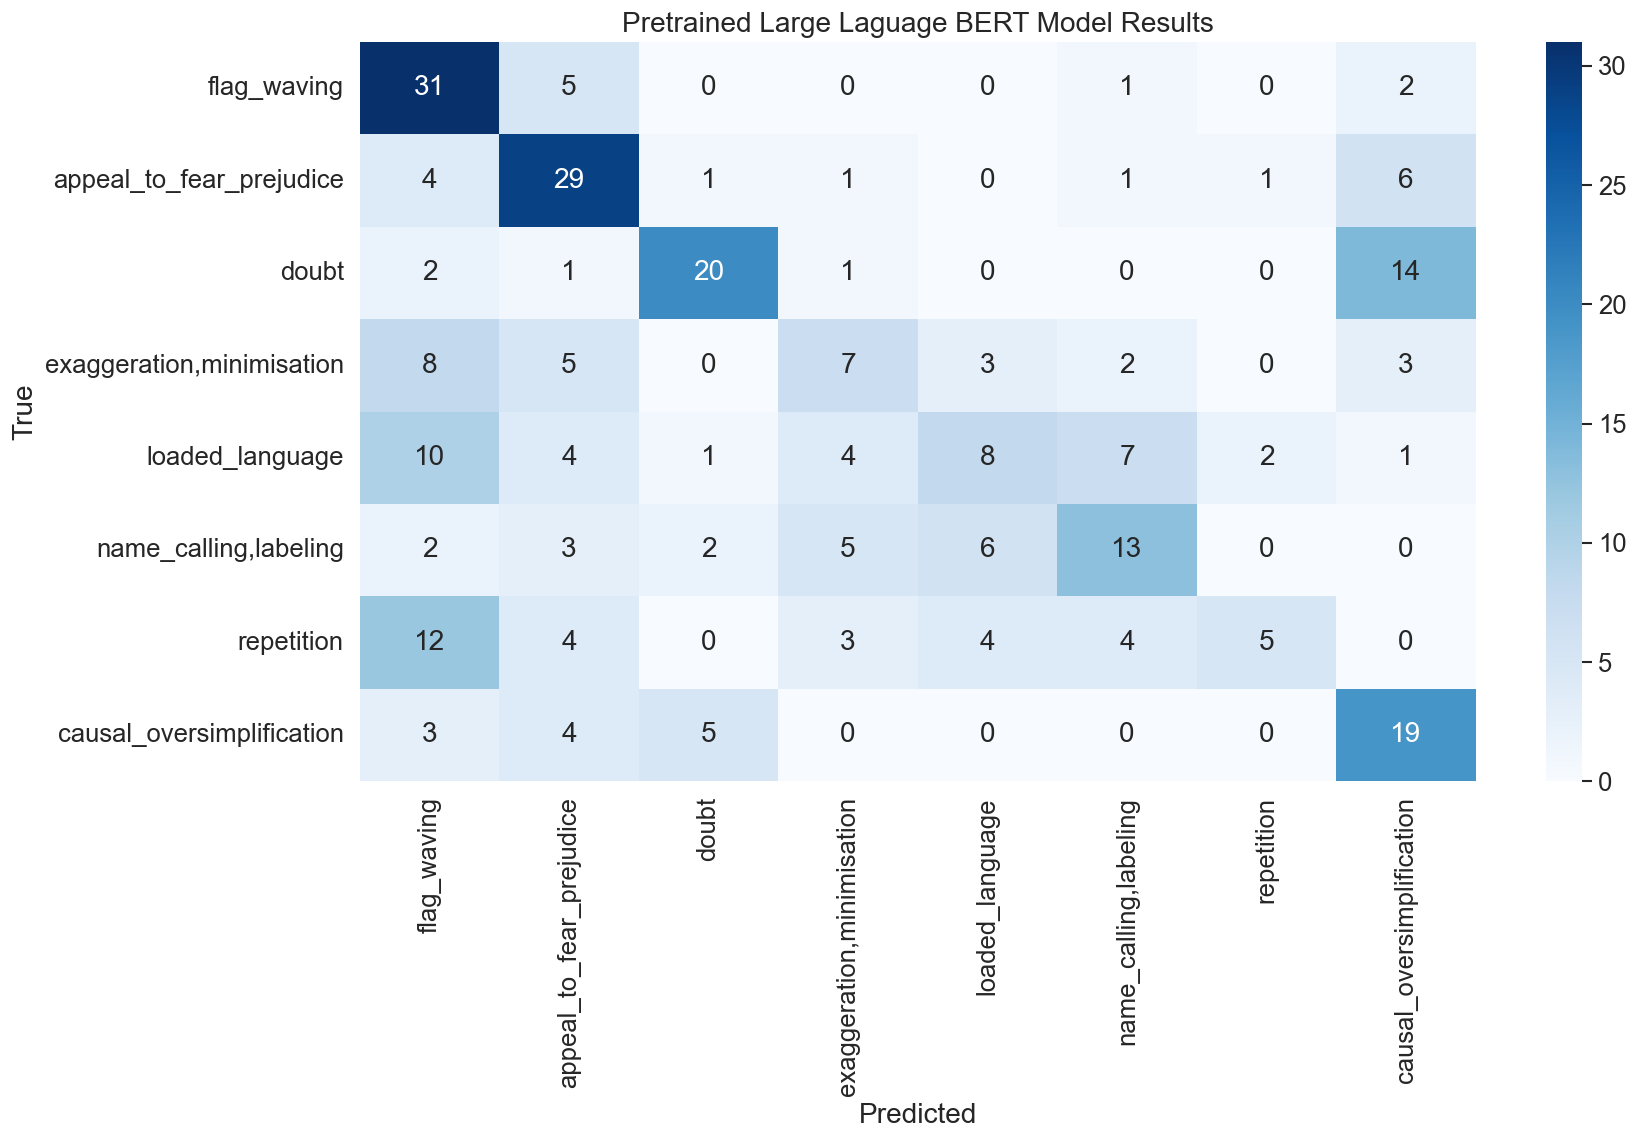

In [695]:
# Create a heatmap with the confusion matrix

sns.set(font_scale=1.4) # Adjust the font size of graphics

plt.figure(figsize=(15,8),dpi=120)
labels = ['flag_waving', 'appeal_to_fear_prejudice', 'doubt', 'exaggeration,minimisation', 'loaded_language', 'name_calling,labeling', 'repetition', 'causal_oversimplification']
ax=sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xticklabels(labels, rotation=90) # Cambiar las etiquetas del eje x
ax.set_yticklabels(labels, rotation=0) # Cambiar las etiquetas del eje x

# Labelling of axes
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Pretrained Large Laguage BERT Model Results")
# Show the graph
plt.show()

# References <a class="anchor" id="5-bullet"></a>

Some of this code was modified from the following sources:

[1] Propaganda detection using sentiment aware ensemble deep ... - IEEE xplore. Available at:
https://ieeexplore.ieee.org/document/9596654/ .

[2] Eea (2018) Eea.corpus/stopwords.py at 6638A3D63D06C209710D22A84F2842CD0FB94F4D · EEA/Eea.corpus,
GitHub. Available at:
https://github.com/eea/eea.corpus/tree/6638a3d63d06c209710d22a84f2842cd0fb94f4d/src/eea.corpus/eea/corpus/processing

[3] fine-grained propaganda detection with fine-tuned Bert - Researchgate. Available at:
https://www.researchgate.net/publication/336999573 Fine-Grained PropagandaDetection with F ine−T uned BERT.

[4] Fine-tuning a pretrained model - transformers 4.7.0 documentation. Available at:
https://huggingface.co/transformers/v4.8.2/training.html .

[5] Briggs, J. (2021) How to train bert, Medium. Towards Data Science. Available at:
https://towardsdatascience.com/how-to-train-bert-aaad00533168 .

[6] Bert fine-tuning tutorial with pytorch (2019) BERT Fine-Tuning Tutorial with PyTorch · Chris McCormick.
Available at: https://mccormickml.com/2019/07/22/BERT-fine-tuning/ .
